<a href="https://colab.research.google.com/github/Luis-Felipe-Moreira-Sa/tcc_ads/blob/main/tcc_comparacao_temporal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mplfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.7 MB/s eta 0:00:00


In [2]:
import yfinance as yf
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from scipy.stats import pearsonr
import mplfinance as mpf
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from datetime import date, timedelta

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler



In [3]:
def download_data_day(ticker, start_date, end_date):
    print("Baixando os dados...")
    data = yf.download(ticker, start_date, end_date, interval='1d')
    return data

# Etapa 2: Pré-processamento dos dados
print("Pré-processando os dados...")
def preprocess_data(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))
    return scaled_data, scaler

def create_sequences(data, sequence_length):
    # Etapa 3: Construção do modelo
    print("Construindo o modelo...")
    X, y = [], []
    for i in range(len(data)-sequence_length):
        X.append(data[i:(i+sequence_length), 0])
        y.append(data[i+sequence_length, 0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y

def build_model():
    print("Construindo o modelo SVR...")
    model = SVR(kernel='rbf', C = 5000)  # Você pode escolher o kernel adequado para seu problema
    return model

def train_model(model, X_train, y_train):
    # Reformula os dados de treinamento para que sejam bidimensionais
    X_train_reshaped = X_train.reshape(X_train.shape[0], -1)

    print("Treinando o modelo SVR...")
    model.fit(X_train_reshaped, y_train)
    return model

def predict(model, X_test, scaler=None):
    print("Fazendo as previsões...")
    predicted = model.predict(X_test)
    if scaler is not None:
        predicted = scaler.inverse_transform(predicted.reshape(-1, 1))
    return predicted

def data_training(data):
    sequence_length = 60
    #Pré-processa os dados
    scaled_data, scaler = preprocess_data(data)
    #Cria as sequências de dados
    X, y = create_sequences(scaled_data, sequence_length)
    #Separa os dados de treinamento e teste
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    print(y_train, "   ", y_test)
    return scaled_data, scaler, X_train, X_test, y_train, y_test

def plot_results(actual, predicted, ticker):
    # Etapa 6: Plotando os resultados
    print("Plotando os resultados...")
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111)

    # Define a largura da linha para 1 (você pode ajustar conforme necessário)
    plt.plot(actual, color='blue', label='Actual ' + ticker + ' Price', linewidth=1)
    plt.plot(predicted, color='red', label='Predicted ' + ticker + ' Price', linewidth=1)
    # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()



def calculate_correlation(actual, predicted):
    # Etapa 7: Cálculo da correlação
    print("Calculando a correlação...")
    corr, _ = pearsonr(actual, predicted)
    return corr


def add_moving_averages(data, window_sizes=[10, 50]):
    for window_size in window_sizes:
        column_name = f'Moving_Average_{window_size}'
        data[column_name] = data['Close'].rolling(window=window_size).mean()
    return data



Pré-processando os dados...


# Download dos Dados

In [4]:
ticker = 'PETR3.SA'
sequence_length = 60
epochs = 20
batch_size = 32

In [5]:
print(ticker)
start_date_day = date.today() - timedelta(days=1915)
end_date_day = date.today() - timedelta(days=91)
data_day = yf.download(tickers=ticker, start=start_date_day, end=end_date_day,interval='1d')
data_test_day = yf.download(tickers=ticker, start=end_date_day, interval='1d')
print(data_day)
print(data_test_day)

PETR3.SA
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2018-08-03  23.250000  23.840000  23.100000  23.219999   8.972010  12428900
2018-08-06  23.230000  23.639999  23.180000  23.299999   9.002922   3632200
2018-08-07  23.600000  23.639999  22.920000  23.209999   8.968147  11463100
2018-08-08  23.250000  23.480000  22.709999  22.740000   8.786542   8715500
2018-08-09  22.850000  22.969999  22.340000  22.760000   8.794271   7934000
...               ...        ...        ...        ...        ...       ...
2023-07-25  34.500000  34.680000  33.799999  34.610001  33.445217   9578200
2023-07-26  34.549999  34.750000  34.020000  34.459999  33.300262  15795200
2023-07-27  34.099998  34.180000  32.500000  32.520000  31.425554  16105600
2023-07-28  32.70

# Dados escalados

In [6]:
scaled_data_1d, scaled_1d, X_train_1d, X_test_1d, y_train_1d, y_test_1d = data_training(data_day)

Construindo o modelo...
[0.63815141 0.63159616 0.61356931 0.64241228 0.61651916 0.59488692
 0.56342179 0.5598164  0.55522776 0.51294657 0.52900687 0.55719431
 0.55653883 0.53523429 0.53359551 0.5126188  0.52605702 0.55621107
 0.5447394  0.55063912 0.5598164  0.58603735 0.56932151 0.57489345
 0.53588983 0.55063912 0.50540801 0.49983607 0.50278593 0.50737463
 0.50081938 0.49164203 0.46279906 0.44936085 0.42969515 0.43035069
 0.44346113 0.4388725  0.47033756 0.51130773 0.52933464 0.53949523
 0.56866597 0.56374956 0.58243195 0.57784331 0.5719436  0.56866597
 0.56571611 0.57325467 0.58112094 0.59324807 0.59783678 0.58341526
 0.59324807 0.60340866 0.56932151 0.58964274 0.60275318 0.60635852
 0.62176334 0.63290723 0.63913465 0.62143557 0.6040642  0.59718124
 0.58505404 0.61914125 0.64241228 0.66338905 0.65552272 0.64372336
 0.66240574 0.66240574 0.66797769 0.66207798 0.63749587 0.63782364
 0.64306782 0.61651916 0.59488692 0.6040642  0.59554239 0.58833167
 0.64208451 0.62536867 0.65191739 0.66

# Treinamento do modelo e previsão

In [7]:
epochs = 30
#Constrói o modelo
model_1d = build_model()
#Treina o modelo
model_1d = train_model(model_1d, X_train_1d, y_train_1d)

Construindo o modelo SVR...
Treinando o modelo SVR...


In [8]:
#Faz previsões
# Antes de fazer as previsões, reformule X_test_1d
X_test_1d_reshaped = X_test_1d.reshape(X_test_1d.shape[0], -1)

# Faz previsões
predicted = predict(model_1d, X_test_1d_reshaped, scaled_1d)
print(y_test_1d)
#Desfaz a escala dos dados
y_test_1d = scaled_1d.inverse_transform(y_test_1d.reshape(-1, 1))
print(y_test_1d)

Fazendo as previsões...
[0.79514914 0.8135037  0.85775156 0.86594559 0.85349062 0.86561776
 0.89216648 0.82137002 0.85611265 0.87807273 0.86004588 0.85742373
 0.81448707 0.80268764 0.80072102 0.79580468 0.76073409 0.77450014
 0.77187799 0.76565057 0.77908878 0.77712216 0.77482784 0.798099
 0.71615865 0.70239261 0.71517528 0.70763679 0.70862003 0.72205837
 0.81809234 0.79482131 0.83579148 0.87118977 0.86496222 0.85381833
 0.84201903 0.87971151 0.85545724 0.84759091 0.87479516 0.92068168
 0.9550966  1.         0.86529005 0.84693537 0.82497542 0.82858081
 0.81055384 0.72795796 0.73156335 0.73451321 0.67715497 0.64175674
 0.64175674 0.62307435 0.61094722 0.64405112 0.67191079 0.66043919
 0.65257287 0.63389048 0.63028514 0.52474594 0.52507371 0.55948869
 0.53883969 0.56112747 0.60078657 0.63389048 0.5965257  0.6089806
 0.59587016 0.59423138 0.57980986 0.55948869 0.55752208 0.53261221
 0.52048507 0.43395609 0.45427726 0.45657158 0.47525397 0.4955752
 0.51819075 0.52835134 0.57391015 0.570960

Predicted Future com técnica Seed

```
# Isto está formatado como código
```



In [9]:
def predict_future(model, X_test, scaler, n_steps=90):
    if len(X_test) < n_steps:
        n_steps = len(X_test) - 1
    for i in range(n_steps):
        last_90 = X_test[-n_steps:]
        predicted = model.predict(last_90)
        predicted = scaler.inverse_transform(predicted)

        # Adicione apenas o último valor da previsão a X_test
        X_test = np.append(X_test, predicted[0, -1])

    return scaler.inverse_transform(X_test[-n_steps:])



In [10]:
predicted_future = predict_future(model_1d, X_test_1d.reshape(1, -1), scaled_1d)

#RF Regressor

In [11]:
from sklearn.ensemble import RandomForestRegressor

In [12]:
def preprocess_data(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))
    return scaled_data, scaler

def create_sequences(data, sequence_length):
    print("Construindo as sequências...")
    X_rf, y_rf = [], []
    for i in range(len(data) - sequence_length):
        X_rf.append(data[i:(i + sequence_length), 0])
        y_rf.append(data[i + sequence_length, 0])
    X_rf, y_rf = np.array(X_rf), np.array(y_rf)
    return X_rf, y_rf

def build_model_rf():
    print("Construindo o modelo Random Forest Regressor...")
    model_rf = RandomForestRegressor(n_estimators=100, random_state=0)  # Você pode ajustar os hiperparâmetros conforme necessário
    return model_rf

def train_model_rf(model_rf, X_train_rf, y_train_rf):
    print("Treinando o modelo Random Forest Regressor...")
    model_rf.fit(X_train_rf, y_train_rf)
    return model_rf

def predict_rf(model_rf, X_test_rf, scaler=None):
    print("Fazendo as previsões com Random Forest Regressor...")
    predicted_rf = model_rf.predict(X_test_rf)
    if scaler is not None:
        predicted_rf = scaler.inverse_transform(predicted_rf.reshape(-1, 1))
    return predicted_rf

def data_training_rf(data_rf):
    sequence_length_rf = 60
    print("Pré-processando os dados...")
    scaled_data_rf, scaler_rf = preprocess_data(data_rf)
    print("Construindo as sequências de dados...")
    X_rf, y_rf = create_sequences(scaled_data_rf, sequence_length_rf)
    train_size_rf = int(len(X_rf) * 0.8)
    X_train_rf, X_test_rf = X_rf[:train_size_rf], X_rf[train_size_rf:]
    y_train_rf, y_test_rf = y_rf[:train_size_rf], y_rf[train_size_rf:]
    return scaled_data_rf, scaler_rf, X_train_rf, X_test_rf, y_train_rf, y_test_rf

def plot_results_rf(actual_rf, predicted_rf, ticker_rf):
    print("Plotando os resultados...")
    fig_rf = plt.figure(figsize=(10, 5))
    ax_rf = fig_rf.add_subplot(111)
    plt.plot(actual_rf, color='blue', label='Actual ' + ticker_rf + ' Price', linewidth=1)
    plt.plot(predicted_rf, color='red', label='Predicted ' + ticker_rf + ' Price', linewidth=1)
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

def calculate_correlation_rf(actual_rf, predicted_rf):
    print("Calculando a correlação...")
    corr_rf, _ = pearsonr(actual_rf, predicted_rf)
    return corr_rf

def add_moving_averages_rf(data_rf, window_sizes_rf=[10, 50]):
    for window_size_rf in window_sizes_rf:
        column_name_rf = f'Moving_Average_{window_size_rf}'
        data_rf[column_name_rf] = data_rf['Close'].rolling(window=window_size_rf).mean()
    return data_rf


#GLM


In [13]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import date, timedelta

# Função para baixar os dados
def download_data_glm(ticker_glm, start_date_glm, end_date_glm):
    print("Baixando os dados...")
    data_glm = yf.download(ticker_glm, start=start_date_glm, end=end_date_glm, interval='1d')
    return data_glm

# Função para pré-processar os dados
def preprocess_data_glm(data_glm):
    scaler_glm = MinMaxScaler(feature_range=(0, 1))
    scaled_data_glm = scaler_glm.fit_transform(data_glm['Close'].values.reshape(-1, 1))
    return scaled_data_glm, scaler_glm

# Função para criar sequências de dados
def create_sequences_glm(data_glm, sequence_length_glm):
    X_glm, y_glm = [], []
    for i in range(len(data_glm) - sequence_length_glm):
        X_seq_glm = data_glm[i:(i + sequence_length_glm), 0]
        y_seq_glm = data_glm[i + sequence_length_glm, 0]
        X_glm.append(X_seq_glm)
        y_glm.append(y_seq_glm)
    X_glm, y_glm = np.array(X_glm), np.array(y_glm)
    return X_glm, y_glm

# Função para construir o modelo GLM (Regressão Linear)
def build_model_glm():
    return LinearRegression()

# Função para treinar o modelo
def train_model_glm(model_glm, X_train_glm, y_train_glm):
    model_glm.fit(X_train_glm, y_train_glm)
    return model_glm

# Função para fazer previsões
def predict_glm(model_glm, X_test_glm):
    return model_glm.predict(X_test_glm)

# Função para calcular métricas de avaliação
def evaluate_glm(y_true_glm, y_pred_glm):
    mae_glm = mean_absolute_error(y_true_glm, y_pred_glm)
    mse_glm = mean_squared_error(y_true_glm, y_pred_glm)
    rmse_glm = np.sqrt(mse_glm)
    r2_glm = r2_score(y_true_glm, y_pred_glm)
    correlation_glm = np.corrcoef(y_test_glm.flatten(), y_pred_glm.flatten())[0, 1]
    return correlation_glm, mae_glm, mse_glm, rmse_glm, r2_glm

Baixando os dados...
[*********************100%%**********************]  1 of 1 completed
Correlation 0.9721157553087552
MAE: 0.624072240821687
MSE: 0.7219311176238944
RMSE: 0.84966529741063
R²: 0.944585635482336


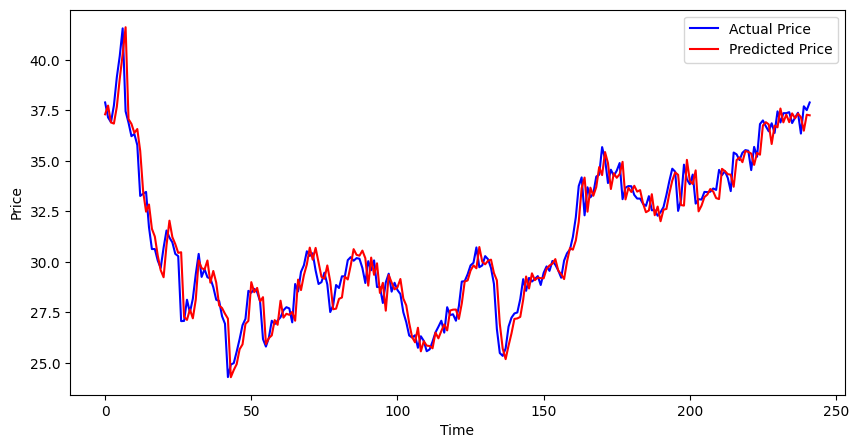

In [14]:
# Parâmetros
ticker_glm = 'PETR3.SA'
start_date_glm = date.today() - timedelta(days=1900)
end_date_glm = date.today() - timedelta(days=30)
sequence_length_glm = 60

# Baixar os dados
data_glm = download_data_glm(ticker_glm, start_date_glm, end_date_glm)

# Pré-processar os dados
scaled_data_glm, scaler_glm = preprocess_data_glm(data_glm)

# Criar sequências de dados
X_glm, y_glm = create_sequences_glm(scaled_data_glm, sequence_length_glm)

# Separar dados de treinamento e teste
train_size_glm = int(len(X_glm) * 0.8)
X_train_glm, X_test_glm = X_glm[:train_size_glm], X_glm[train_size_glm:]
y_train_glm, y_test_glm = y_glm[:train_size_glm], y_glm[train_size_glm:]

# Construir o modelo
model_glm = build_model_glm()

# Treinar o modelo
model_glm = train_model_glm(model_glm, X_train_glm, y_train_glm)

# Fazer previsões
y_pred_glm = predict_glm(model_glm, X_test_glm)

# Desfazer a escala das previsões
y_pred_glm = scaler_glm.inverse_transform(y_pred_glm.reshape(-1, 1))

# Desfazer a escala dos dados de teste
y_test_glm = scaler_glm.inverse_transform(y_test_glm.reshape(-1, 1))

# Calcular métricas de avaliação
correlation_glm, mae_glm, mse_glm, rmse_glm, r2_glm = evaluate_glm(y_test_glm, y_pred_glm)

print("Correlation", correlation_glm)
print("MAE:", mae_glm)
print("MSE:", mse_glm)
print("RMSE:", rmse_glm)
print("R²:", r2_glm)

# Plotar resultados
plt.figure(figsize=(10, 5))
plt.plot(y_test_glm, label='Actual Price', color='blue')
plt.plot(y_pred_glm, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

PETR3.SA
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Pré-processando os dados...
Construindo as sequências de dados...
Construindo as sequências...
Construindo o modelo Random Forest Regressor...
Treinando o modelo Random Forest Regressor...
Fazendo as previsões com Random Forest Regressor...
Plotando os resultados...


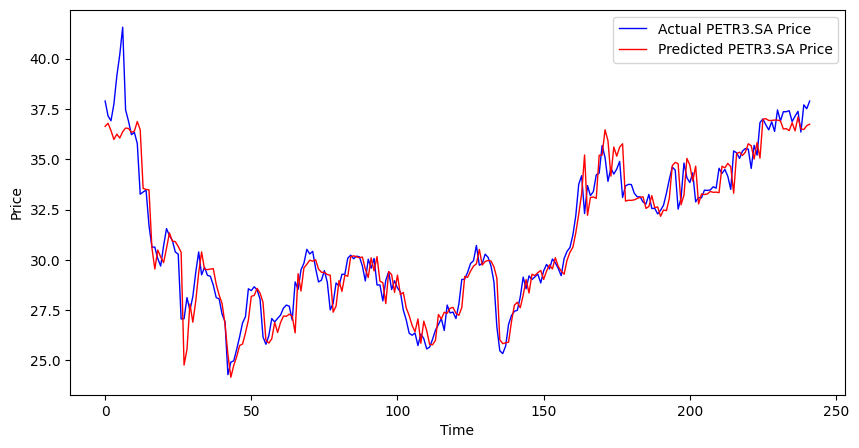

In [15]:
ticker_rf = 'PETR3.SA'
sequence_length_rf = 60

print(ticker_rf)
start_date_day_rf = date.today() - timedelta(days=1900)
end_date_day_rf = date.today() - timedelta(days=30)
data_day_rf = yf.download(tickers=ticker_rf, start=start_date_day_rf, end=end_date_day_rf, interval='1d')
data_test_day_rf = yf.download(tickers=ticker_rf, start=end_date_day_rf, interval='1d')

scaled_data_1d_rf, scaled_1d_rf, X_train_1d_rf, X_test_1d_rf, y_train_1d_rf, y_test_1d_rf = data_training_rf(data_day_rf)

model_1d_rf = build_model_rf()
model_1d_rf = train_model_rf(model_1d_rf, X_train_1d_rf, y_train_1d_rf)

predicted_rf = predict_rf(model_1d_rf, X_test_1d_rf)

# Desfaz a escala dos dados
y_test_1d_rf = scaled_1d_rf.inverse_transform(y_test_1d_rf.reshape(-1, 1))

# Desfaz a escala dos dados
predicted_rf = scaled_1d_rf.inverse_transform(predicted_rf.reshape(-1, 1))

# Plotar resultados
plot_results_rf(y_test_1d_rf, predicted_rf, ticker_rf)

PETR3.SA
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Pré-processando os dados...
Construindo as sequências de dados...
Construindo as sequências...
Construindo o modelo Random Forest Regressor...
Treinando o modelo Random Forest Regressor...
Fazendo as previsões com Random Forest Regressor...
Plotando os resultados...


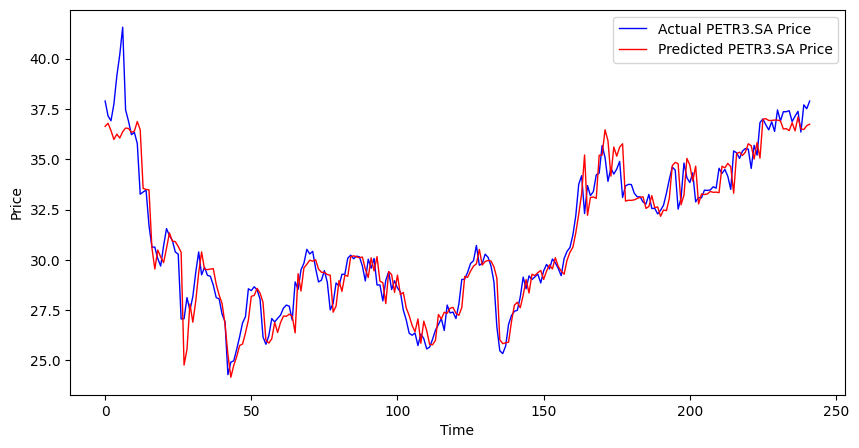

In [16]:
ticker_rf = 'PETR3.SA'
sequence_length_rf = 60

print(ticker_rf)
start_date_day_rf = date.today() - timedelta(days=1900)
end_date_day_rf = date.today() - timedelta(days=30)
data_day_rf = yf.download(tickers=ticker_rf, start=start_date_day_rf, end=end_date_day_rf, interval='1d')
data_test_day_rf = yf.download(tickers=ticker_rf, start=end_date_day_rf, interval='1d')

scaled_data_1d_rf, scaled_1d_rf, X_train_1d_rf, X_test_1d_rf, y_train_1d_rf, y_test_1d_rf = data_training_rf(data_day_rf)

model_1d_rf = build_model_rf()
model_1d_rf = train_model_rf(model_1d_rf, X_train_1d_rf, y_train_1d_rf)

predicted_rf = predict_rf(model_1d_rf, X_test_1d_rf)

# Desfaz a escala dos dados
y_test_1d_rf = scaled_1d_rf.inverse_transform(y_test_1d_rf.reshape(-1, 1))

# Desfaz a escala dos dados
predicted_rf = scaled_1d_rf.inverse_transform(predicted_rf.reshape(-1, 1))

# Plotar resultados
plot_results_rf(y_test_1d_rf, predicted_rf, ticker_rf)

Pré-processando os dados...
Construindo as sequências de dados...
Construindo as sequências...
Construindo o modelo Random Forest Regressor...
Treinando o modelo Random Forest Regressor com médias móveis...
Fazendo as previsões com Random Forest Regressor...
Plotando os resultados...


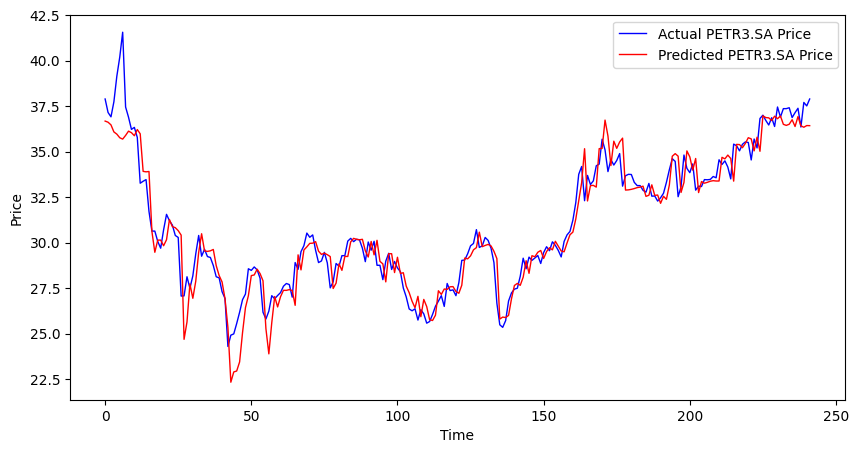

In [17]:
from sklearn.impute import SimpleImputer

def data_training_rf_med(data_rf):
    sequence_length_rf = 60
    print("Pré-processando os dados...")
    scaled_data_rf_med, scaler_rf_med = preprocess_data(data_rf)
    print("Construindo as sequências de dados...")
    X_rf_med, y_rf_med = create_sequences_rf(scaled_data_rf_med, sequence_length_rf)
    train_size_rf_med = int(len(X_rf_med) * 0.8)
    X_train_rf_med, X_test_rf_med = X_rf_med[:train_size_rf_med], X_rf_med[train_size_rf_med:]
    y_train_rf_med, y_test_rf_med = y_rf_med[:train_size_rf_med], y_rf_med[train_size_rf_med:]

    # Tratar valores ausentes
    imputer = SimpleImputer(strategy='mean')
    X_train_rf_med = imputer.fit_transform(X_train_rf_med)
    X_test_rf_med = imputer.transform(X_test_rf_med)

    return scaled_data_rf_med, scaler_rf_med, X_train_rf_med, X_test_rf_med, y_train_rf_med, y_test_rf_med

def create_sequences_rf(data_rf, sequence_length_rf):
    print("Construindo as sequências...")
    X_rf_med, y_rf_med = [], []
    for i in range(len(data_rf) - sequence_length_rf):
        X_seq_rf = data_rf[i:(i + sequence_length_rf), 0]

        # Adiciona as médias móveis como atributos adicionais
        for window_size_rf in [10, 50]:
            rolling_mean = pd.Series(data_rf[i:(i + sequence_length_rf), 0]).rolling(window=window_size_rf).mean()
            X_seq_rf = np.append(X_seq_rf, rolling_mean)

        X_rf_med.append(X_seq_rf)
        y_rf_med.append(data_rf[i + sequence_length_rf, 0])
    X_rf_med, y_rf_med = np.array(X_rf_med), np.array(y_rf_med)
    return X_rf_med, y_rf_med

def build_model_rf_med():
    print("Construindo o modelo Random Forest Regressor com médias móveis...")
    model_rf_med = RandomForestRegressor(n_estimators=100, random_state=0)  # Você pode ajustar os hiperparâmetros conforme necessário
    return model_rf_med

def train_model_rf_med(model_rf_med, X_train_rf_med, y_train_rf_med):
    print("Treinando o modelo Random Forest Regressor com médias móveis...")
    model_rf_med.fit(X_train_rf_med, y_train_rf_med)
    return model_rf_med

def predict_rf_med(model_rf_med, X_test_rf_med, scaler=None):
    print("Fazendo as previsões com Random Forest Regressor com médias móveis...")
    predicted_rf_med = model_rf_med.predict(X_test_rf_med)
    if scaler is not None:
        predicted_rf_med = scaler.inverse_transform(predicted_rf_med.reshape(-1, 1))
    return predicted_rf_med

def calculate_correlation_rf_med(actual_rf_med, predicted_rf_med):
    print("Calculando a correlação com Random Forest Regressor com médias móveis...")
    corr_rf_med, _ = pearsonr(actual_rf_med, predicted_rf_med)
    return corr_rf_med

def add_moving_averages_rf_med(data_rf, window_sizes_rf=[10, 50]):
    for window_size_rf in window_sizes_rf:
        column_name_rf = f'Moving_Average_{window_size_rf}_rf_med'
        data_rf[column_name_rf] = data_rf['Close'].rolling(window=window_size_rf).mean()
    return data_rf
# ...

# Treinamento do modelo Random Forest Regressor com médias móveis
scaled_data_1d_rf_med, scaled_1d_rf_med, X_train_1d_rf_med, X_test_1d_rf_med, y_train_1d_rf_med, y_test_1d_rf_med = data_training_rf_med(data_day_rf)

model_1d_rf_med = build_model_rf()
model_1d_rf_med = train_model_rf_med(model_1d_rf_med, X_train_1d_rf_med, y_train_1d_rf_med)

predicted_rf_med = predict_rf(model_1d_rf_med, X_test_1d_rf_med)

# Desfaz a escala dos dados
y_test_1d_rf_med = scaled_1d_rf_med.inverse_transform(y_test_1d_rf_med.reshape(-1, 1))

# Desfaz a escala dos dados
predicted_rf_med = scaled_1d_rf_med.inverse_transform(predicted_rf_med.reshape(-1, 1))

# Plotar resultados
plot_results_rf(y_test_1d_rf_med, predicted_rf_med, ticker_rf)


# Plotando *dados*

Plotando os resultados...


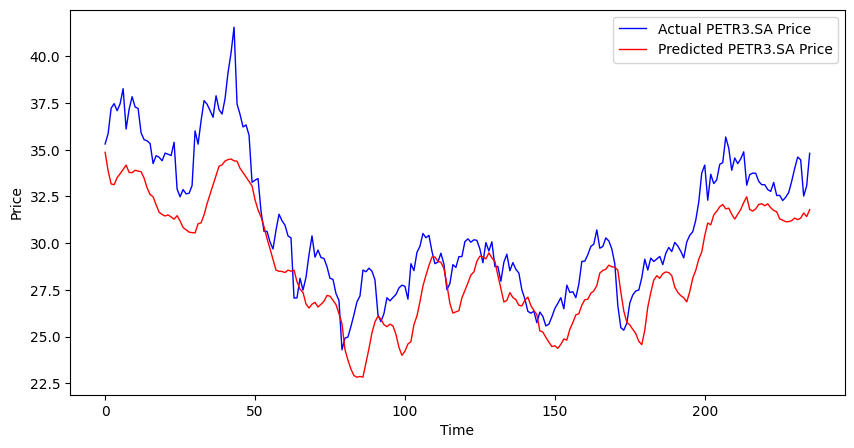

In [18]:
plot_results(y_test_1d, predicted, ticker)

# Correlação

In [19]:
def calculate_correlation(predicted_future, y_test_1d):
    # Calcular a correlação entre predicted_future e y_test_1d
    correlation = pd.Series(predicted_future).corr(pd.Series(y_test_1d))

    return correlation

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math


In [21]:
# print(" Length of y_test_1d:", len(y_test_1d))
# print(" Length of predicted:", len(predicted))

# Reshape both arrays to have compatible shapes for correlation calculation
y_test_1d = y_test_1d.reshape(-1)  # Flatten y_test_1d
predicted = predicted.reshape(-1)  # Flatten y_test_future

# Now both arrays should have the same shape and can be used for correlation calculation
correlation = calculate_correlation(y_test_1d, predicted)
print(f"A correlação entre y_test_1d e predicted é: {correlation}")

# Calcular o Erro Médio Absoluto (MAE)
mae = mean_absolute_error(y_test_1d, predicted)
print(f"MAE: {mae}")

# Calcular o Erro Médio Quadrático (MSE)
mse = mean_squared_error(y_test_1d, predicted)
print(f"MSE: {mse}")

# Calcular a Raiz do Erro Médio Quadrático (RMSE)
rmse = math.sqrt(mse)
print(f"RMSE: {rmse}")

# Calcular o R² (Coeficiente de Determinação)
r2 = r2_score(y_test_1d, predicted)
print(f"R²: {r2}")

A correlação entre y_test_1d e predicted é: 0.9174459323924621
MAE: 2.1215507916663983
MSE: 6.223447145068499
RMSE: 2.4946837765673826
R²: 0.5227942289724394


In [22]:
# Reshape both arrays to have compatible shapes for correlation calculation
y_test_1d = y_test_1d.reshape(-1)  # Flatten y_test_1d
predicted = predicted.reshape(-1)  # Flatten y_test_future
# Métricas do SVR
corr_svr = calculate_correlation(predicted, y_test_1d)
mae_svr = mean_absolute_error(y_test_1d, predicted)
mse_svr = mean_squared_error(y_test_1d, predicted)
rmse_svr = math.sqrt(mse_svr)
r2_svr = r2_score(y_test_1d, predicted)

y_test_1d_rf = y_test_1d_rf.reshape(-1)  # Flatten y_test_1d
predicted_rf = predicted_rf.reshape(-1)  # Flatten y_test_future
# Métricas do Random Forest Regressor
corr_rf = calculate_correlation_rf(predicted_rf, y_test_1d_rf)
mae_rf = mean_absolute_error(y_test_1d_rf, predicted_rf)
mse_rf = mean_squared_error(y_test_1d_rf, predicted_rf)
rmse_rf = math.sqrt(mse_rf)
r2_rf = r2_score(y_test_1d_rf, predicted_rf)


# Reshape both arrays to have compatible shapes for correlation calculation
y_test_1d_rf_med = y_test_1d_rf_med.reshape(-1)  # Flatten y_test_1d
predicted_rf_med = predicted_rf_med.reshape(-1)  # Flatten y_test_future

# Métricas do Random Forest Regressor com medias moveis
corr_rf_med = calculate_correlation_rf(predicted_rf_med, y_test_1d_rf_med)
mae_rf_med = mean_absolute_error(y_test_1d_rf_med, predicted_rf_med)
mse_rf_med = mean_squared_error(y_test_1d_rf_med, predicted_rf_med)
rmse_rf_med = math.sqrt(mse_rf)
r2_rf_med = r2_score(y_test_1d_rf, predicted_rf_med)

# Criar um DataFrame para comparar as métricas
data = {
    'Métrica': ['Correlação', 'MAE', 'MSE', 'RMSE', 'R²'],
    'SVR': [corr_svr, mae_svr, mse_svr, rmse_svr, r2_svr],
    'Random Forest': [corr_rf, mae_rf, mse_rf, rmse_rf, r2_rf],
    'Random Forest_Medias': [corr_rf_med, mae_rf_med, mse_rf_med, rmse_rf_med, r2_rf_med],
    'GLM': [correlation_glm, mae_glm, mse_glm, rmse_glm, r2_glm]
}

print("\t\t", ticker)
df_metrics = pd.DataFrame(data)
data_petr4 = df_metrics
display(df_metrics)

Calculando a correlação...
Calculando a correlação...
		 PETR3.SA


,Métrica,SVR,Random Forest,Random Forest_Medias,GLM
0,Correlação,0.917446,0.961770,0.955327,0.972116
1,MAE,2.121551,0.691228,0.748826,0.624072
2,MSE,6.223447,0.985889,1.174258,0.721931
3,RMSE,2.494684,0.992919,0.992919,0.849665
4,R²,0.522794,0.924325,0.909866,0.944586


#BOVA11

Pré-processando os dados...
BOVA11.SA
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2018-08-03   77.470001   78.940002   77.370003   78.660004   78.660004   
2018-08-06   78.800003   78.919998   78.129997   78.239998   78.239998   
2018-08-07   78.769997   78.940002   77.129997   77.489998   77.489998   
2018-08-08   77.570000   78.120003   76.180000   76.320000   76.320000   
2018-08-09   76.650002   76.699997   75.400002   75.959999   75.959999   
...                ...         ...         ...         ...         ...   
2023-07-25  118.970001  119.169998  117.980003  117.980003  117.980003   
2023-07-26  117.849998  118.889999  117.550003  118.739998  118.739998   
2023-07-27  118.660004  118.800003  116.000000  116.040001  116.040001   
2023-07-28

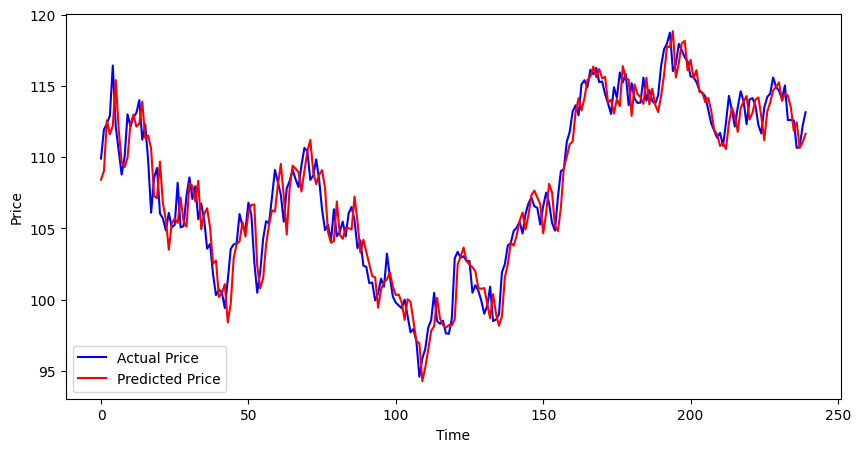

BOVA11.SA
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Pré-processando os dados...
Construindo as sequências de dados...
Construindo as sequências...
Construindo o modelo Random Forest Regressor...
Treinando o modelo Random Forest Regressor...
Fazendo as previsões com Random Forest Regressor...
Plotando os resultados...


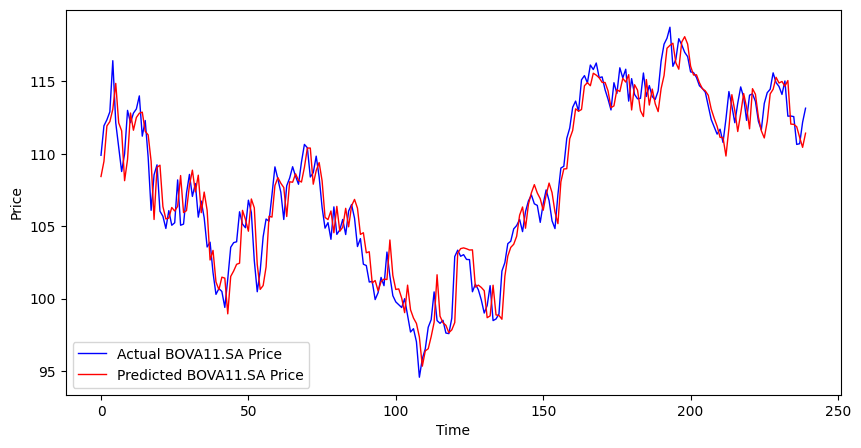

BOVA11.SA
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Pré-processando os dados...
Construindo as sequências de dados...
Construindo as sequências...
Construindo o modelo Random Forest Regressor...
Treinando o modelo Random Forest Regressor...
Fazendo as previsões com Random Forest Regressor...
Plotando os resultados...


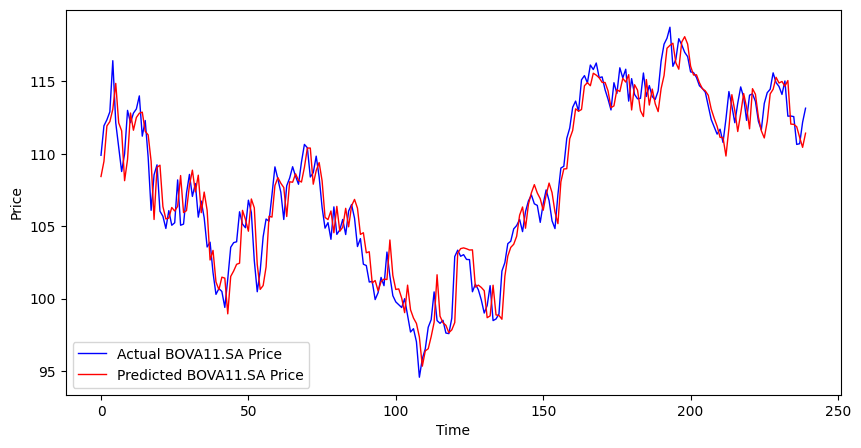

Pré-processando os dados...
Construindo as sequências de dados...
Construindo as sequências...
Construindo o modelo Random Forest Regressor...
Treinando o modelo Random Forest Regressor com médias móveis...
Fazendo as previsões com Random Forest Regressor...
Plotando os resultados...


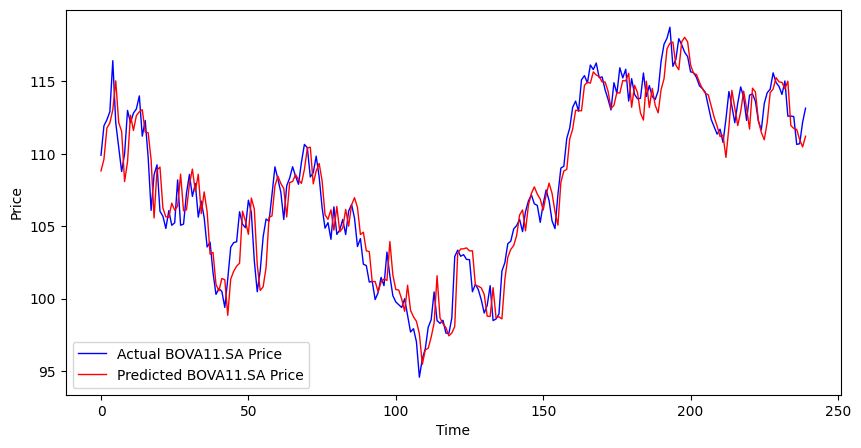

Plotando os resultados...


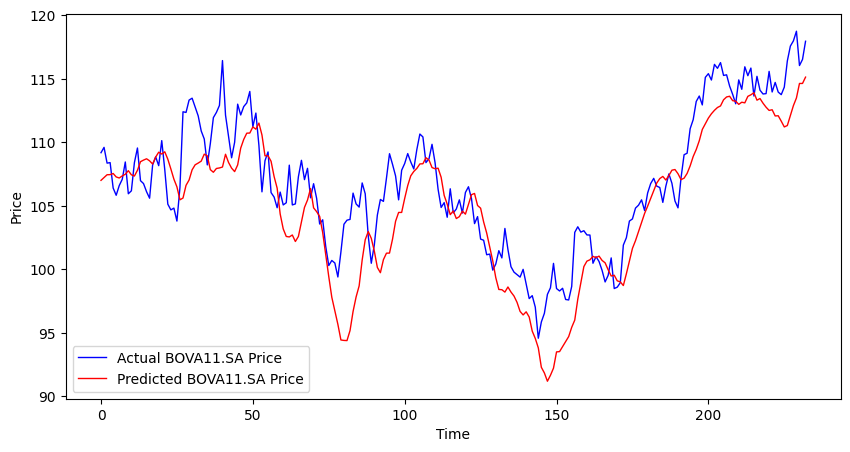

A correlação entre y_test_1d e predicted é: 0.8864689221235882
MAE: 2.535074424167502
MSE: 10.362246378581027
RMSE: 3.2190443269052738
R²: 0.6334880901137747
Calculando a correlação...
Calculando a correlação...


,Métrica,SVR,Random Forest,Random Forest_Medias,GLM
0,Correlação,0.886469,0.965818,0.965147,0.965294
1,MAE,2.535074,1.194782,1.204515,1.210391
2,MSE,10.362246,2.265734,2.310390,2.331918
3,RMSE,3.219044,1.505236,1.505236,1.527062
4,R²,0.633488,0.932724,0.931398,0.930759


In [23]:
# -*- coding: utf-8 -*-
"""svr.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1KjiimiSBdMdGFPkNaAOG8qm_oOgiIemH
"""

!pip install mplfinance

import yfinance as yf
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from scipy.stats import pearsonr
import mplfinance as mpf
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from datetime import date, timedelta

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

def download_data_day(ticker, start_date, end_date):
    print("Baixando os dados...")
    data = yf.download(ticker, start_date, end_date, interval='1d')
    return data

# Etapa 2: Pré-processamento dos dados
print("Pré-processando os dados...")
def preprocess_data(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))
    return scaled_data, scaler

def create_sequences(data, sequence_length):
    # Etapa 3: Construção do modelo
    print("Construindo o modelo...")
    X, y = [], []
    for i in range(len(data)-sequence_length):
        X.append(data[i:(i+sequence_length), 0])
        y.append(data[i+sequence_length, 0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y

def build_model():
    print("Construindo o modelo SVR...")
    model = SVR(kernel='rbf', C = 5000)  # Você pode escolher o kernel adequado para seu problema
    return model

def train_model(model, X_train, y_train):
    # Reformula os dados de treinamento para que sejam bidimensionais
    X_train_reshaped = X_train.reshape(X_train.shape[0], -1)

    print("Treinando o modelo SVR...")
    model.fit(X_train_reshaped, y_train)
    return model

def predict(model, X_test, scaler=None):
    print("Fazendo as previsões...")
    predicted = model.predict(X_test)
    if scaler is not None:
        predicted = scaler.inverse_transform(predicted.reshape(-1, 1))
    return predicted

def data_training(data):
    sequence_length = 60
    #Pré-processa os dados
    scaled_data, scaler = preprocess_data(data)
    #Cria as sequências de dados
    X, y = create_sequences(scaled_data, sequence_length)
    #Separa os dados de treinamento e teste
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    print(y_train, "   ", y_test)
    return scaled_data, scaler, X_train, X_test, y_train, y_test

def plot_results(actual, predicted, ticker):
    # Etapa 6: Plotando os resultados
    print("Plotando os resultados...")
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111)

    # Define a largura da linha para 1 (você pode ajustar conforme necessário)
    plt.plot(actual, color='blue', label='Actual ' + ticker + ' Price', linewidth=1)
    plt.plot(predicted, color='red', label='Predicted ' + ticker + ' Price', linewidth=1)
    # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()



def calculate_correlation(actual, predicted):
    # Etapa 7: Cálculo da correlação
    print("Calculando a correlação...")
    corr, _ = pearsonr(actual, predicted)
    return corr


def add_moving_averages(data, window_sizes=[10, 50]):
    for window_size in window_sizes:
        column_name = f'Moving_Average_{window_size}'
        data[column_name] = data['Close'].rolling(window=window_size).mean()
    return data

"""# Download dos Dados"""

ticker = 'BOVA11.SA'
sequence_length = 60
epochs = 20
batch_size = 32

print(ticker)
start_date_day = date.today() - timedelta(days=1915)
end_date_day = date.today() - timedelta(days=91)
data_day = yf.download(tickers=ticker, start=start_date_day, end=end_date_day,interval='1d')
data_test_day = yf.download(tickers=ticker, start=end_date_day, interval='1d')
print(data_day)
print(data_test_day)

"""# Dados escalados"""

scaled_data_1d, scaled_1d, X_train_1d, X_test_1d, y_train_1d, y_test_1d = data_training(data_day)

"""# Treinamento do modelo e previsão"""

epochs = 30
#Constrói o modelo
model_1d = build_model()
#Treina o modelo
model_1d = train_model(model_1d, X_train_1d, y_train_1d)

#Faz previsões
# Antes de fazer as previsões, reformule X_test_1d
X_test_1d_reshaped = X_test_1d.reshape(X_test_1d.shape[0], -1)

# Faz previsões
predicted = predict(model_1d, X_test_1d_reshaped, scaled_1d)
print(y_test_1d)
#Desfaz a escala dos dados
y_test_1d = scaled_1d.inverse_transform(y_test_1d.reshape(-1, 1))
print(y_test_1d)

"""Predicted Future com técnica Seed

```
# Isto está formatado como código
```


"""

def predict_future(model, X_test, scaler, n_steps=90):
    if len(X_test) < n_steps:
        n_steps = len(X_test) - 1
    for i in range(n_steps):
        last_90 = X_test[-n_steps:]
        predicted = model.predict(last_90)
        predicted = scaler.inverse_transform(predicted)

        # Adicione apenas o último valor da previsão a X_test
        X_test = np.append(X_test, predicted[0, -1])

    return scaler.inverse_transform(X_test[-n_steps:])

predicted_future = predict_future(model_1d, X_test_1d.reshape(1, -1), scaled_1d)

"""#RF Regressor"""

from sklearn.ensemble import RandomForestRegressor

def preprocess_data(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))
    return scaled_data, scaler

def create_sequences(data, sequence_length):
    print("Construindo as sequências...")
    X_rf, y_rf = [], []
    for i in range(len(data) - sequence_length):
        X_rf.append(data[i:(i + sequence_length), 0])
        y_rf.append(data[i + sequence_length, 0])
    X_rf, y_rf = np.array(X_rf), np.array(y_rf)
    return X_rf, y_rf

def build_model_rf():
    print("Construindo o modelo Random Forest Regressor...")
    model_rf = RandomForestRegressor(n_estimators=100, random_state=0)  # Você pode ajustar os hiperparâmetros conforme necessário
    return model_rf

def train_model_rf(model_rf, X_train_rf, y_train_rf):
    print("Treinando o modelo Random Forest Regressor...")
    model_rf.fit(X_train_rf, y_train_rf)
    return model_rf

def predict_rf(model_rf, X_test_rf, scaler=None):
    print("Fazendo as previsões com Random Forest Regressor...")
    predicted_rf = model_rf.predict(X_test_rf)
    if scaler is not None:
        predicted_rf = scaler.inverse_transform(predicted_rf.reshape(-1, 1))
    return predicted_rf

def data_training_rf(data_rf):
    sequence_length_rf = 60
    print("Pré-processando os dados...")
    scaled_data_rf, scaler_rf = preprocess_data(data_rf)
    print("Construindo as sequências de dados...")
    X_rf, y_rf = create_sequences(scaled_data_rf, sequence_length_rf)
    train_size_rf = int(len(X_rf) * 0.8)
    X_train_rf, X_test_rf = X_rf[:train_size_rf], X_rf[train_size_rf:]
    y_train_rf, y_test_rf = y_rf[:train_size_rf], y_rf[train_size_rf:]
    return scaled_data_rf, scaler_rf, X_train_rf, X_test_rf, y_train_rf, y_test_rf

def plot_results_rf(actual_rf, predicted_rf, ticker_rf):
    print("Plotando os resultados...")
    fig_rf = plt.figure(figsize=(10, 5))
    ax_rf = fig_rf.add_subplot(111)
    plt.plot(actual_rf, color='blue', label='Actual ' + ticker_rf + ' Price', linewidth=1)
    plt.plot(predicted_rf, color='red', label='Predicted ' + ticker_rf + ' Price', linewidth=1)
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

def calculate_correlation_rf(actual_rf, predicted_rf):
    print("Calculando a correlação...")
    corr_rf, _ = pearsonr(actual_rf, predicted_rf)
    return corr_rf

def add_moving_averages_rf(data_rf, window_sizes_rf=[10, 50]):
    for window_size_rf in window_sizes_rf:
        column_name_rf = f'Moving_Average_{window_size_rf}'
        data_rf[column_name_rf] = data_rf['Close'].rolling(window=window_size_rf).mean()
    return data_rf

"""#GLM

"""

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import date, timedelta

# Função para baixar os dados
def download_data_glm(ticker_glm, start_date_glm, end_date_glm):
    print("Baixando os dados...")
    data_glm = yf.download(ticker_glm, start=start_date_glm, end=end_date_glm, interval='1d')
    return data_glm

# Função para pré-processar os dados
def preprocess_data_glm(data_glm):
    scaler_glm = MinMaxScaler(feature_range=(0, 1))
    scaled_data_glm = scaler_glm.fit_transform(data_glm['Close'].values.reshape(-1, 1))
    return scaled_data_glm, scaler_glm

# Função para criar sequências de dados
def create_sequences_glm(data_glm, sequence_length_glm):
    X_glm, y_glm = [], []
    for i in range(len(data_glm) - sequence_length_glm):
        X_seq_glm = data_glm[i:(i + sequence_length_glm), 0]
        y_seq_glm = data_glm[i + sequence_length_glm, 0]
        X_glm.append(X_seq_glm)
        y_glm.append(y_seq_glm)
    X_glm, y_glm = np.array(X_glm), np.array(y_glm)
    return X_glm, y_glm

# Função para construir o modelo GLM (Regressão Linear)
def build_model_glm():
    return LinearRegression()

# Função para treinar o modelo
def train_model_glm(model_glm, X_train_glm, y_train_glm):
    model_glm.fit(X_train_glm, y_train_glm)
    return model_glm

# Função para fazer previsões
def predict_glm(model_glm, X_test_glm):
    return model_glm.predict(X_test_glm)

# Função para calcular métricas de avaliação
def evaluate_glm(y_true_glm, y_pred_glm):
    mae_glm = mean_absolute_error(y_true_glm, y_pred_glm)
    mse_glm = mean_squared_error(y_true_glm, y_pred_glm)
    rmse_glm = np.sqrt(mse_glm)
    r2_glm = r2_score(y_true_glm, y_pred_glm)
    correlation_glm = np.corrcoef(y_test_glm.flatten(), y_pred_glm.flatten())[0, 1]
    return correlation_glm, mae_glm, mse_glm, rmse_glm, r2_glm

# Parâmetros
ticker_glm = 'BOVA11.SA'
start_date_glm = date.today() - timedelta(days=1900)
end_date_glm = date.today() - timedelta(days=30)
sequence_length_glm = 60

# Baixar os dados
data_glm = download_data_glm(ticker_glm, start_date_glm, end_date_glm)

# Pré-processar os dados
scaled_data_glm, scaler_glm = preprocess_data_glm(data_glm)

# Criar sequências de dados
X_glm, y_glm = create_sequences_glm(scaled_data_glm, sequence_length_glm)

# Separar dados de treinamento e teste
train_size_glm = int(len(X_glm) * 0.8)
X_train_glm, X_test_glm = X_glm[:train_size_glm], X_glm[train_size_glm:]
y_train_glm, y_test_glm = y_glm[:train_size_glm], y_glm[train_size_glm:]

# Construir o modelo
model_glm = build_model_glm()

# Treinar o modelo
model_glm = train_model_glm(model_glm, X_train_glm, y_train_glm)

# Fazer previsões
y_pred_glm = predict_glm(model_glm, X_test_glm)

# Desfazer a escala das previsões
y_pred_glm = scaler_glm.inverse_transform(y_pred_glm.reshape(-1, 1))

# Desfazer a escala dos dados de teste
y_test_glm = scaler_glm.inverse_transform(y_test_glm.reshape(-1, 1))

# Calcular métricas de avaliação
correlation_glm, mae_glm, mse_glm, rmse_glm, r2_glm = evaluate_glm(y_test_glm, y_pred_glm)

print("Correlation", correlation_glm)
print("MAE:", mae_glm)
print("MSE:", mse_glm)
print("RMSE:", rmse_glm)
print("R²:", r2_glm)

# Plotar resultados
plt.figure(figsize=(10, 5))
plt.plot(y_test_glm, label='Actual Price', color='blue')
plt.plot(y_pred_glm, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

ticker_rf = 'BOVA11.SA'
sequence_length_rf = 60

print(ticker_rf)
start_date_day_rf = date.today() - timedelta(days=1900)
end_date_day_rf = date.today() - timedelta(days=30)
data_day_rf = yf.download(tickers=ticker_rf, start=start_date_day_rf, end=end_date_day_rf, interval='1d')
data_test_day_rf = yf.download(tickers=ticker_rf, start=end_date_day_rf, interval='1d')

scaled_data_1d_rf, scaled_1d_rf, X_train_1d_rf, X_test_1d_rf, y_train_1d_rf, y_test_1d_rf = data_training_rf(data_day_rf)

model_1d_rf = build_model_rf()
model_1d_rf = train_model_rf(model_1d_rf, X_train_1d_rf, y_train_1d_rf)

predicted_rf = predict_rf(model_1d_rf, X_test_1d_rf)

# Desfaz a escala dos dados
y_test_1d_rf = scaled_1d_rf.inverse_transform(y_test_1d_rf.reshape(-1, 1))

# Desfaz a escala dos dados
predicted_rf = scaled_1d_rf.inverse_transform(predicted_rf.reshape(-1, 1))

# Plotar resultados
plot_results_rf(y_test_1d_rf, predicted_rf, ticker_rf)

ticker_rf = 'BOVA11.SA'
sequence_length_rf = 60

print(ticker_rf)
start_date_day_rf = date.today() - timedelta(days=1900)
end_date_day_rf = date.today() - timedelta(days=30)
data_day_rf = yf.download(tickers=ticker_rf, start=start_date_day_rf, end=end_date_day_rf, interval='1d')
data_test_day_rf = yf.download(tickers=ticker_rf, start=end_date_day_rf, interval='1d')

scaled_data_1d_rf, scaled_1d_rf, X_train_1d_rf, X_test_1d_rf, y_train_1d_rf, y_test_1d_rf = data_training_rf(data_day_rf)

model_1d_rf = build_model_rf()
model_1d_rf = train_model_rf(model_1d_rf, X_train_1d_rf, y_train_1d_rf)

predicted_rf = predict_rf(model_1d_rf, X_test_1d_rf)

# Desfaz a escala dos dados
y_test_1d_rf = scaled_1d_rf.inverse_transform(y_test_1d_rf.reshape(-1, 1))

# Desfaz a escala dos dados
predicted_rf = scaled_1d_rf.inverse_transform(predicted_rf.reshape(-1, 1))

# Plotar resultados
plot_results_rf(y_test_1d_rf, predicted_rf, ticker_rf)

from sklearn.impute import SimpleImputer

def data_training_rf_med(data_rf):
    sequence_length_rf = 60
    print("Pré-processando os dados...")
    scaled_data_rf_med, scaler_rf_med = preprocess_data(data_rf)
    print("Construindo as sequências de dados...")
    X_rf_med, y_rf_med = create_sequences_rf(scaled_data_rf_med, sequence_length_rf)
    train_size_rf_med = int(len(X_rf_med) * 0.8)
    X_train_rf_med, X_test_rf_med = X_rf_med[:train_size_rf_med], X_rf_med[train_size_rf_med:]
    y_train_rf_med, y_test_rf_med = y_rf_med[:train_size_rf_med], y_rf_med[train_size_rf_med:]

    # Tratar valores ausentes
    imputer = SimpleImputer(strategy='mean')
    X_train_rf_med = imputer.fit_transform(X_train_rf_med)
    X_test_rf_med = imputer.transform(X_test_rf_med)

    return scaled_data_rf_med, scaler_rf_med, X_train_rf_med, X_test_rf_med, y_train_rf_med, y_test_rf_med

def create_sequences_rf(data_rf, sequence_length_rf):
    print("Construindo as sequências...")
    X_rf_med, y_rf_med = [], []
    for i in range(len(data_rf) - sequence_length_rf):
        X_seq_rf = data_rf[i:(i + sequence_length_rf), 0]

        # Adiciona as médias móveis como atributos adicionais
        for window_size_rf in [10, 50]:
            rolling_mean = pd.Series(data_rf[i:(i + sequence_length_rf), 0]).rolling(window=window_size_rf).mean()
            X_seq_rf = np.append(X_seq_rf, rolling_mean)

        X_rf_med.append(X_seq_rf)
        y_rf_med.append(data_rf[i + sequence_length_rf, 0])
    X_rf_med, y_rf_med = np.array(X_rf_med), np.array(y_rf_med)
    return X_rf_med, y_rf_med

def build_model_rf_med():
    print("Construindo o modelo Random Forest Regressor com médias móveis...")
    model_rf_med = RandomForestRegressor(n_estimators=100, random_state=0)  # Você pode ajustar os hiperparâmetros conforme necessário
    return model_rf_med

def train_model_rf_med(model_rf_med, X_train_rf_med, y_train_rf_med):
    print("Treinando o modelo Random Forest Regressor com médias móveis...")
    model_rf_med.fit(X_train_rf_med, y_train_rf_med)
    return model_rf_med

def predict_rf_med(model_rf_med, X_test_rf_med, scaler=None):
    print("Fazendo as previsões com Random Forest Regressor com médias móveis...")
    predicted_rf_med = model_rf_med.predict(X_test_rf_med)
    if scaler is not None:
        predicted_rf_med = scaler.inverse_transform(predicted_rf_med.reshape(-1, 1))
    return predicted_rf_med

def calculate_correlation_rf_med(actual_rf_med, predicted_rf_med):
    print("Calculando a correlação com Random Forest Regressor com médias móveis...")
    corr_rf_med, _ = pearsonr(actual_rf_med, predicted_rf_med)
    return corr_rf_med

def add_moving_averages_rf_med(data_rf, window_sizes_rf=[10, 50]):
    for window_size_rf in window_sizes_rf:
        column_name_rf = f'Moving_Average_{window_size_rf}_rf_med'
        data_rf[column_name_rf] = data_rf['Close'].rolling(window=window_size_rf).mean()
    return data_rf
# ...

# Treinamento do modelo Random Forest Regressor com médias móveis
scaled_data_1d_rf_med, scaled_1d_rf_med, X_train_1d_rf_med, X_test_1d_rf_med, y_train_1d_rf_med, y_test_1d_rf_med = data_training_rf_med(data_day_rf)

model_1d_rf_med = build_model_rf()
model_1d_rf_med = train_model_rf_med(model_1d_rf_med, X_train_1d_rf_med, y_train_1d_rf_med)

predicted_rf_med = predict_rf(model_1d_rf_med, X_test_1d_rf_med)

# Desfaz a escala dos dados
y_test_1d_rf_med = scaled_1d_rf_med.inverse_transform(y_test_1d_rf_med.reshape(-1, 1))

# Desfaz a escala dos dados
predicted_rf_med = scaled_1d_rf_med.inverse_transform(predicted_rf_med.reshape(-1, 1))

# Plotar resultados
plot_results_rf(y_test_1d_rf_med, predicted_rf_med, ticker_rf)

"""# Plotando *dados*"""

plot_results(y_test_1d, predicted, ticker)

"""# Correlação"""

def calculate_correlation(predicted_future, y_test_1d):
    # Calcular a correlação entre predicted_future e y_test_1d
    correlation = pd.Series(predicted_future).corr(pd.Series(y_test_1d))

    return correlation

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math

# print(" Length of y_test_1d:", len(y_test_1d))
# print(" Length of predicted:", len(predicted))

# Reshape both arrays to have compatible shapes for correlation calculation
y_test_1d = y_test_1d.reshape(-1)  # Flatten y_test_1d
predicted = predicted.reshape(-1)  # Flatten y_test_future

# Now both arrays should have the same shape and can be used for correlation calculation
correlation = calculate_correlation(y_test_1d, predicted)
print(f"A correlação entre y_test_1d e predicted é: {correlation}")

# Calcular o Erro Médio Absoluto (MAE)
mae = mean_absolute_error(y_test_1d, predicted)
print(f"MAE: {mae}")

# Calcular o Erro Médio Quadrático (MSE)
mse = mean_squared_error(y_test_1d, predicted)
print(f"MSE: {mse}")

# Calcular a Raiz do Erro Médio Quadrático (RMSE)
rmse = math.sqrt(mse)
print(f"RMSE: {rmse}")

# Calcular o R² (Coeficiente de Determinação)
r2 = r2_score(y_test_1d, predicted)
print(f"R²: {r2}")

# Reshape both arrays to have compatible shapes for correlation calculation
y_test_1d = y_test_1d.reshape(-1)  # Flatten y_test_1d
predicted = predicted.reshape(-1)  # Flatten y_test_future
# Métricas do SVR
corr_svr = calculate_correlation(predicted, y_test_1d)
mae_svr = mean_absolute_error(y_test_1d, predicted)
mse_svr = mean_squared_error(y_test_1d, predicted)
rmse_svr = math.sqrt(mse_svr)
r2_svr = r2_score(y_test_1d, predicted)


y_test_1d_rf = y_test_1d_rf.reshape(-1)  # Flatten y_test_1d
predicted_rf = predicted_rf.reshape(-1)  # Flatten y_test_future
# Métricas do Random Forest Regressor
corr_rf = calculate_correlation_rf(predicted_rf, y_test_1d_rf)
mae_rf = mean_absolute_error(y_test_1d_rf, predicted_rf)
mse_rf = mean_squared_error(y_test_1d_rf, predicted_rf)
rmse_rf = math.sqrt(mse_rf)
r2_rf = r2_score(y_test_1d_rf, predicted_rf)


# Reshape both arrays to have compatible shapes for correlation calculation
y_test_1d_rf_med = y_test_1d_rf_med.reshape(-1)  # Flatten y_test_1d
predicted_rf_med = predicted_rf_med.reshape(-1)  # Flatten y_test_future

# Métricas do Random Forest Regressor com medias moveis
corr_rf_med = calculate_correlation_rf(predicted_rf_med, y_test_1d_rf_med)
mae_rf_med = mean_absolute_error(y_test_1d_rf_med, predicted_rf_med)
mse_rf_med = mean_squared_error(y_test_1d_rf_med, predicted_rf_med)
rmse_rf_med = math.sqrt(mse_rf)
r2_rf_med = r2_score(y_test_1d_rf, predicted_rf_med)

# Criar um DataFrame para comparar as métricas
data = {
    'Métrica': ['Correlação', 'MAE', 'MSE', 'RMSE', 'R²'],
    'SVR': [corr_svr, mae_svr, mse_svr, rmse_svr, r2_svr],
    'Random Forest': [corr_rf, mae_rf, mse_rf, rmse_rf, r2_rf],
    'Random Forest_Medias': [corr_rf_med, mae_rf_med, mse_rf_med, rmse_rf_med, r2_rf_med],
    'GLM': [correlation_glm, mae_glm, mse_glm, rmse_glm, r2_glm]
}

df_metrics = pd.DataFrame(data)

data_bova11 = df_metrics
display(df_metrics)

#ITUB4


Pré-processando os dados...
ITUB4.SA
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2018-08-03  30.700001  31.286667  30.700001  31.200001  25.430729  18072450
2018-08-06  31.326666  31.440001  30.799999  30.973333  25.245979  13164000
2018-08-07  31.166666  31.233334  30.346666  30.786667  25.093838  20860350
2018-08-08  30.786667  31.133333  30.046665  30.066666  24.506960  21587550
2018-08-09  30.333332  30.433332  29.680000  29.906666  24.376547  15496050
...               ...        ...        ...        ...        ...       ...
2023-07-25  28.950001  28.950001  28.320000  28.600000  28.266020  34900000
2023-07-26  28.590000  28.799999  28.330000  28.760000  28.424152  33564400
2023-07-27  28.719999  28.719999  28.090000  28.120001  27.791624

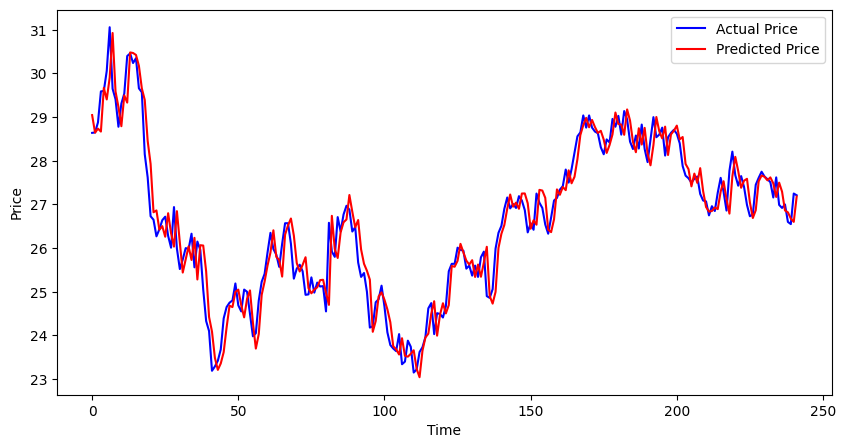

ITUB4.SA
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Pré-processando os dados...
Construindo as sequências de dados...
Construindo as sequências...
Construindo o modelo Random Forest Regressor...
Treinando o modelo Random Forest Regressor...
Fazendo as previsões com Random Forest Regressor...
Plotando os resultados...


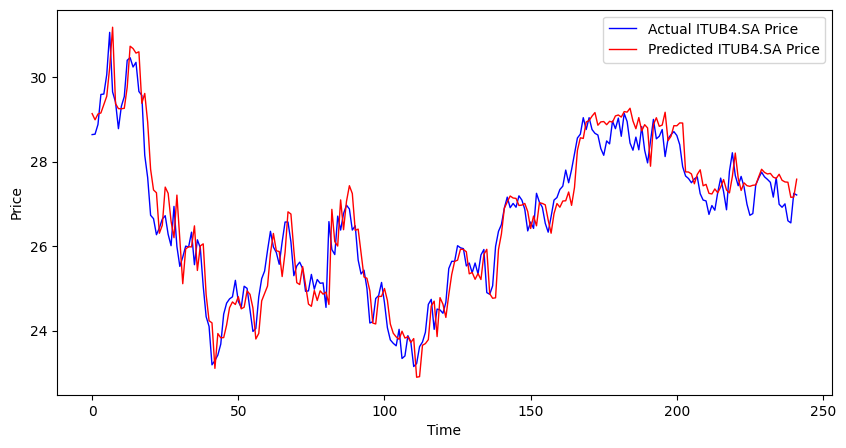

ITUB4.SA
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Pré-processando os dados...
Construindo as sequências de dados...
Construindo as sequências...
Construindo o modelo Random Forest Regressor...
Treinando o modelo Random Forest Regressor...
Fazendo as previsões com Random Forest Regressor...
Plotando os resultados...


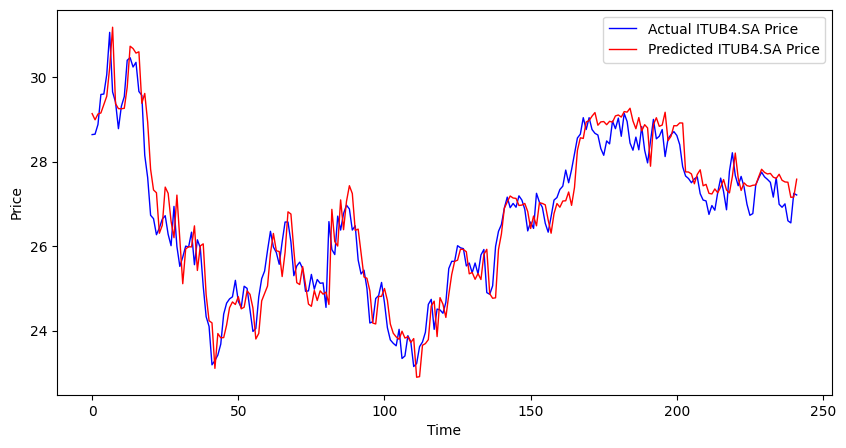

Pré-processando os dados...
Construindo as sequências de dados...
Construindo as sequências...
Construindo o modelo Random Forest Regressor...
Treinando o modelo Random Forest Regressor com médias móveis...
Fazendo as previsões com Random Forest Regressor...
Plotando os resultados...


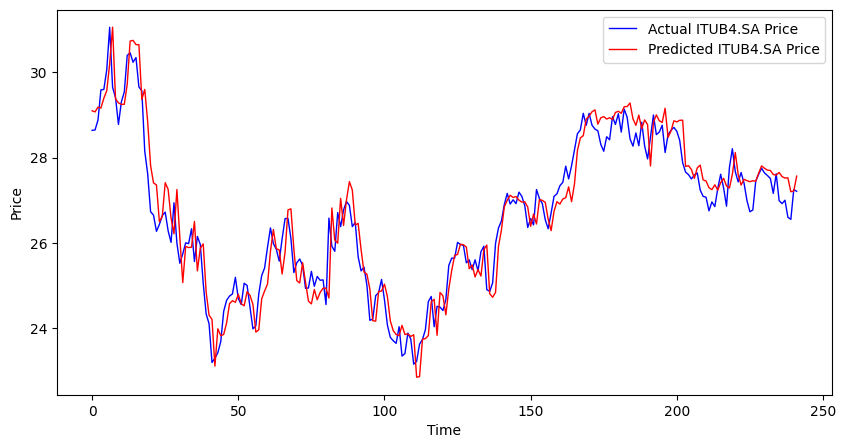

Plotando os resultados...


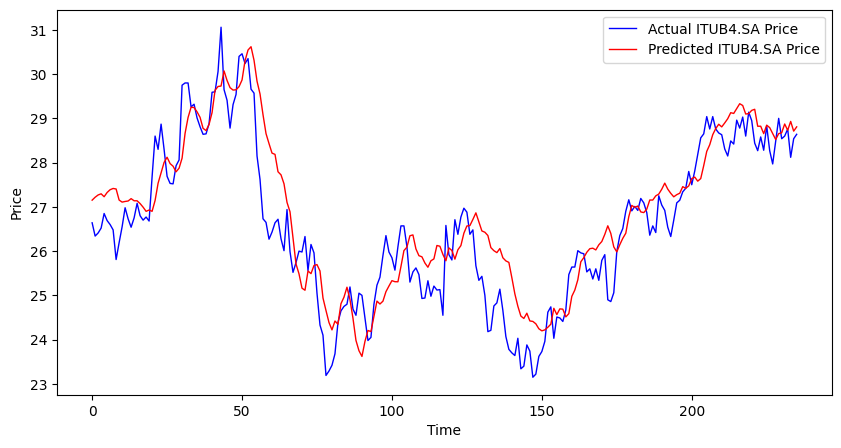

A correlação entre y_test_1d e predicted é: 0.9076646185750629
MAE: 0.6350618448264377
MSE: 0.6494462448948495
RMSE: 0.8058822773177541
R²: 0.7971351710689113
Calculando a correlação...
Calculando a correlação...


,Métrica,SVR,Random Forest,Random Forest_Medias,GLM
0,Correlação,0.907665,0.959697,0.959131,0.963039
1,MAE,0.635062,0.410209,0.413307,0.358637
2,MSE,0.649446,0.271210,0.272479,0.218740
3,RMSE,0.805882,0.520778,0.520778,0.467696
4,R²,0.797135,0.907987,0.907557,0.925789


In [24]:
# -*- coding: utf-8 -*-
"""svr.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1KjiimiSBdMdGFPkNaAOG8qm_oOgiIemH
"""

!pip install mplfinance

import yfinance as yf
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from scipy.stats import pearsonr
import mplfinance as mpf
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from datetime import date, timedelta

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler


def download_data_day(ticker, start_date, end_date):
    print("Baixando os dados...")
    data = yf.download(ticker, start_date, end_date, interval='1d')
    return data


# Etapa 2: Pré-processamento dos dados
print("Pré-processando os dados...")
def preprocess_data(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))
    return scaled_data, scaler


def create_sequences(data, sequence_length):
    # Etapa 3: Construção do modelo
    print("Construindo o modelo...")
    X, y = [], []
    for i in range(len(data)-sequence_length):
        X.append(data[i:(i+sequence_length), 0])
        y.append(data[i+sequence_length, 0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y


def build_model():
    print("Construindo o modelo SVR...")
    model = SVR(kernel='rbf', C = 5000)  # Você pode escolher o kernel adequado para seu problema
    return model


def train_model(model, X_train, y_train):
    # Reformula os dados de treinamento para que sejam bidimensionais
    X_train_reshaped = X_train.reshape(X_train.shape[0], -1)

    print("Treinando o modelo SVR...")
    model.fit(X_train_reshaped, y_train)
    return model


def predict(model, X_test, scaler=None):
    print("Fazendo as previsões...")
    predicted = model.predict(X_test)
    if scaler is not None:
        predicted = scaler.inverse_transform(predicted.reshape(-1, 1))
    return predicted


def data_training(data):
    sequence_length = 60
    #Pré-processa os dados
    scaled_data, scaler = preprocess_data(data)
    #Cria as sequências de dados
    X, y = create_sequences(scaled_data, sequence_length)
    #Separa os dados de treinamento e teste
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    print(y_train, "   ", y_test)
    return scaled_data, scaler, X_train, X_test, y_train, y_test


def plot_results(actual, predicted, ticker):
    # Etapa 6: Plotando os resultados
    print("Plotando os resultados...")
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111)

    # Define a largura da linha para 1 (você pode ajustar conforme necessário)
    plt.plot(actual, color='blue', label='Actual ' + ticker + ' Price', linewidth=1)
    plt.plot(predicted, color='red', label='Predicted ' + ticker + ' Price', linewidth=1)
    # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()



def calculate_correlation(actual, predicted):
    # Etapa 7: Cálculo da correlação
    print("Calculando a correlação...")
    corr, _ = pearsonr(actual, predicted)
    return corr


def add_moving_averages(data, window_sizes=[10, 50]):
    for window_size in window_sizes:
        column_name = f'Moving_Average_{window_size}'
        data[column_name] = data['Close'].rolling(window=window_size).mean()
    return data

"""# Download dos Dados"""

ticker = 'ITUB4.SA'
sequence_length = 60
epochs = 20
batch_size = 32

print(ticker)
start_date_day = date.today() - timedelta(days=1915)
end_date_day = date.today() - timedelta(days=91)
data_day = yf.download(tickers=ticker, start=start_date_day, end=end_date_day,interval='1d')
data_test_day = yf.download(tickers=ticker, start=end_date_day, interval='1d')
print(data_day)
print(data_test_day)

"""# Dados escalados"""

scaled_data_1d, scaled_1d, X_train_1d, X_test_1d, y_train_1d, y_test_1d = data_training(data_day)

"""# Treinamento do modelo e previsão"""

epochs = 30
#Constrói o modelo
model_1d = build_model()
#Treina o modelo
model_1d = train_model(model_1d, X_train_1d, y_train_1d)

#Faz previsões
# Antes de fazer as previsões, reformule X_test_1d
X_test_1d_reshaped = X_test_1d.reshape(X_test_1d.shape[0], -1)

# Faz previsões
predicted = predict(model_1d, X_test_1d_reshaped, scaled_1d)
print(y_test_1d)
#Desfaz a escala dos dados
y_test_1d = scaled_1d.inverse_transform(y_test_1d.reshape(-1, 1))
print(y_test_1d)

"""Predicted Future com técnica Seed

```
# Isto está formatado como código
```


"""

def predict_future(model, X_test, scaler, n_steps=90):
    if len(X_test) < n_steps:
        n_steps = len(X_test) - 1
    for i in range(n_steps):
        last_90 = X_test[-n_steps:]
        predicted = model.predict(last_90)
        predicted = scaler.inverse_transform(predicted)

        # Adicione apenas o último valor da previsão a X_test
        X_test = np.append(X_test, predicted[0, -1])

    return scaler.inverse_transform(X_test[-n_steps:])

predicted_future = predict_future(model_1d, X_test_1d.reshape(1, -1), scaled_1d)

"""#RF Regressor"""

from sklearn.ensemble import RandomForestRegressor

def preprocess_data(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))
    return scaled_data, scaler

def create_sequences(data, sequence_length):
    print("Construindo as sequências...")
    X_rf, y_rf = [], []
    for i in range(len(data) - sequence_length):
        X_rf.append(data[i:(i + sequence_length), 0])
        y_rf.append(data[i + sequence_length, 0])
    X_rf, y_rf = np.array(X_rf), np.array(y_rf)
    return X_rf, y_rf

def build_model_rf():
    print("Construindo o modelo Random Forest Regressor...")
    model_rf = RandomForestRegressor(n_estimators=100, random_state=0)  # Você pode ajustar os hiperparâmetros conforme necessário
    return model_rf

def train_model_rf(model_rf, X_train_rf, y_train_rf):
    print("Treinando o modelo Random Forest Regressor...")
    model_rf.fit(X_train_rf, y_train_rf)
    return model_rf

def predict_rf(model_rf, X_test_rf, scaler=None):
    print("Fazendo as previsões com Random Forest Regressor...")
    predicted_rf = model_rf.predict(X_test_rf)
    if scaler is not None:
        predicted_rf = scaler.inverse_transform(predicted_rf.reshape(-1, 1))
    return predicted_rf

def data_training_rf(data_rf):
    sequence_length_rf = 60
    print("Pré-processando os dados...")
    scaled_data_rf, scaler_rf = preprocess_data(data_rf)
    print("Construindo as sequências de dados...")
    X_rf, y_rf = create_sequences(scaled_data_rf, sequence_length_rf)
    train_size_rf = int(len(X_rf) * 0.8)
    X_train_rf, X_test_rf = X_rf[:train_size_rf], X_rf[train_size_rf:]
    y_train_rf, y_test_rf = y_rf[:train_size_rf], y_rf[train_size_rf:]
    return scaled_data_rf, scaler_rf, X_train_rf, X_test_rf, y_train_rf, y_test_rf

def plot_results_rf(actual_rf, predicted_rf, ticker_rf):
    print("Plotando os resultados...")
    fig_rf = plt.figure(figsize=(10, 5))
    ax_rf = fig_rf.add_subplot(111)
    plt.plot(actual_rf, color='blue', label='Actual ' + ticker_rf + ' Price', linewidth=1)
    plt.plot(predicted_rf, color='red', label='Predicted ' + ticker_rf + ' Price', linewidth=1)
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

def calculate_correlation_rf(actual_rf, predicted_rf):
    print("Calculando a correlação...")
    corr_rf, _ = pearsonr(actual_rf, predicted_rf)
    return corr_rf

def add_moving_averages_rf(data_rf, window_sizes_rf=[10, 50]):
    for window_size_rf in window_sizes_rf:
        column_name_rf = f'Moving_Average_{window_size_rf}'
        data_rf[column_name_rf] = data_rf['Close'].rolling(window=window_size_rf).mean()
    return data_rf

"""#GLM

"""

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import date, timedelta

# Função para baixar os dados
def download_data_glm(ticker_glm, start_date_glm, end_date_glm):
    print("Baixando os dados...")
    data_glm = yf.download(ticker_glm, start=start_date_glm, end=end_date_glm, interval='1d')
    return data_glm

# Função para pré-processar os dados
def preprocess_data_glm(data_glm):
    scaler_glm = MinMaxScaler(feature_range=(0, 1))
    scaled_data_glm = scaler_glm.fit_transform(data_glm['Close'].values.reshape(-1, 1))
    return scaled_data_glm, scaler_glm

# Função para criar sequências de dados
def create_sequences_glm(data_glm, sequence_length_glm):
    X_glm, y_glm = [], []
    for i in range(len(data_glm) - sequence_length_glm):
        X_seq_glm = data_glm[i:(i + sequence_length_glm), 0]
        y_seq_glm = data_glm[i + sequence_length_glm, 0]
        X_glm.append(X_seq_glm)
        y_glm.append(y_seq_glm)
    X_glm, y_glm = np.array(X_glm), np.array(y_glm)
    return X_glm, y_glm

# Função para construir o modelo GLM (Regressão Linear)
def build_model_glm():
    return LinearRegression()

# Função para treinar o modelo
def train_model_glm(model_glm, X_train_glm, y_train_glm):
    model_glm.fit(X_train_glm, y_train_glm)
    return model_glm

# Função para fazer previsões
def predict_glm(model_glm, X_test_glm):
    return model_glm.predict(X_test_glm)

# Função para calcular métricas de avaliação
def evaluate_glm(y_true_glm, y_pred_glm):
    mae_glm = mean_absolute_error(y_true_glm, y_pred_glm)
    mse_glm = mean_squared_error(y_true_glm, y_pred_glm)
    rmse_glm = np.sqrt(mse_glm)
    r2_glm = r2_score(y_true_glm, y_pred_glm)
    correlation_glm = np.corrcoef(y_test_glm.flatten(), y_pred_glm.flatten())[0, 1]
    return correlation_glm, mae_glm, mse_glm, rmse_glm, r2_glm

# Parâmetros
ticker_glm = 'ITUB4.SA'
start_date_glm = date.today() - timedelta(days=1900)
end_date_glm = date.today() - timedelta(days=30)
sequence_length_glm = 60

# Baixar os dados
data_glm = download_data_glm(ticker_glm, start_date_glm, end_date_glm)

# Pré-processar os dados
scaled_data_glm, scaler_glm = preprocess_data_glm(data_glm)

# Criar sequências de dados
X_glm, y_glm = create_sequences_glm(scaled_data_glm, sequence_length_glm)

# Separar dados de treinamento e teste
train_size_glm = int(len(X_glm) * 0.8)
X_train_glm, X_test_glm = X_glm[:train_size_glm], X_glm[train_size_glm:]
y_train_glm, y_test_glm = y_glm[:train_size_glm], y_glm[train_size_glm:]

# Construir o modelo
model_glm = build_model_glm()

# Treinar o modelo
model_glm = train_model_glm(model_glm, X_train_glm, y_train_glm)

# Fazer previsões
y_pred_glm = predict_glm(model_glm, X_test_glm)

# Desfazer a escala das previsões
y_pred_glm = scaler_glm.inverse_transform(y_pred_glm.reshape(-1, 1))

# Desfazer a escala dos dados de teste
y_test_glm = scaler_glm.inverse_transform(y_test_glm.reshape(-1, 1))

# Calcular métricas de avaliação
correlation_glm, mae_glm, mse_glm, rmse_glm, r2_glm = evaluate_glm(y_test_glm, y_pred_glm)

print("Correlation", correlation_glm)
print("MAE:", mae_glm)
print("MSE:", mse_glm)
print("RMSE:", rmse_glm)
print("R²:", r2_glm)

# Plotar resultados
plt.figure(figsize=(10, 5))
plt.plot(y_test_glm, label='Actual Price', color='blue')
plt.plot(y_pred_glm, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

ticker_rf = 'ITUB4.SA'
sequence_length_rf = 60

print(ticker_rf)
start_date_day_rf = date.today() - timedelta(days=1900)
end_date_day_rf = date.today() - timedelta(days=30)
data_day_rf = yf.download(tickers=ticker_rf, start=start_date_day_rf, end=end_date_day_rf, interval='1d')
data_test_day_rf = yf.download(tickers=ticker_rf, start=end_date_day_rf, interval='1d')

scaled_data_1d_rf, scaled_1d_rf, X_train_1d_rf, X_test_1d_rf, y_train_1d_rf, y_test_1d_rf = data_training_rf(data_day_rf)

model_1d_rf = build_model_rf()
model_1d_rf = train_model_rf(model_1d_rf, X_train_1d_rf, y_train_1d_rf)

predicted_rf = predict_rf(model_1d_rf, X_test_1d_rf)

# Desfaz a escala dos dados
y_test_1d_rf = scaled_1d_rf.inverse_transform(y_test_1d_rf.reshape(-1, 1))

# Desfaz a escala dos dados
predicted_rf = scaled_1d_rf.inverse_transform(predicted_rf.reshape(-1, 1))

# Plotar resultados
plot_results_rf(y_test_1d_rf, predicted_rf, ticker_rf)

ticker_rf = 'ITUB4.SA'
sequence_length_rf = 60

print(ticker_rf)
start_date_day_rf = date.today() - timedelta(days=1900)
end_date_day_rf = date.today() - timedelta(days=30)
data_day_rf = yf.download(tickers=ticker_rf, start=start_date_day_rf, end=end_date_day_rf, interval='1d')
data_test_day_rf = yf.download(tickers=ticker_rf, start=end_date_day_rf, interval='1d')

scaled_data_1d_rf, scaled_1d_rf, X_train_1d_rf, X_test_1d_rf, y_train_1d_rf, y_test_1d_rf = data_training_rf(data_day_rf)

model_1d_rf = build_model_rf()
model_1d_rf = train_model_rf(model_1d_rf, X_train_1d_rf, y_train_1d_rf)

predicted_rf = predict_rf(model_1d_rf, X_test_1d_rf)

# Desfaz a escala dos dados
y_test_1d_rf = scaled_1d_rf.inverse_transform(y_test_1d_rf.reshape(-1, 1))

# Desfaz a escala dos dados
predicted_rf = scaled_1d_rf.inverse_transform(predicted_rf.reshape(-1, 1))

# Plotar resultados
plot_results_rf(y_test_1d_rf, predicted_rf, ticker_rf)

from sklearn.impute import SimpleImputer

def data_training_rf_med(data_rf):
    sequence_length_rf = 60
    print("Pré-processando os dados...")
    scaled_data_rf_med, scaler_rf_med = preprocess_data(data_rf)
    print("Construindo as sequências de dados...")
    X_rf_med, y_rf_med = create_sequences_rf(scaled_data_rf_med, sequence_length_rf)
    train_size_rf_med = int(len(X_rf_med) * 0.8)
    X_train_rf_med, X_test_rf_med = X_rf_med[:train_size_rf_med], X_rf_med[train_size_rf_med:]
    y_train_rf_med, y_test_rf_med = y_rf_med[:train_size_rf_med], y_rf_med[train_size_rf_med:]

    # Tratar valores ausentes
    imputer = SimpleImputer(strategy='mean')
    X_train_rf_med = imputer.fit_transform(X_train_rf_med)
    X_test_rf_med = imputer.transform(X_test_rf_med)

    return scaled_data_rf_med, scaler_rf_med, X_train_rf_med, X_test_rf_med, y_train_rf_med, y_test_rf_med

def create_sequences_rf(data_rf, sequence_length_rf):
    print("Construindo as sequências...")
    X_rf_med, y_rf_med = [], []
    for i in range(len(data_rf) - sequence_length_rf):
        X_seq_rf = data_rf[i:(i + sequence_length_rf), 0]

        # Adiciona as médias móveis como atributos adicionais
        for window_size_rf in [10, 50]:
            rolling_mean = pd.Series(data_rf[i:(i + sequence_length_rf), 0]).rolling(window=window_size_rf).mean()
            X_seq_rf = np.append(X_seq_rf, rolling_mean)

        X_rf_med.append(X_seq_rf)
        y_rf_med.append(data_rf[i + sequence_length_rf, 0])
    X_rf_med, y_rf_med = np.array(X_rf_med), np.array(y_rf_med)
    return X_rf_med, y_rf_med

def build_model_rf_med():
    print("Construindo o modelo Random Forest Regressor com médias móveis...")
    model_rf_med = RandomForestRegressor(n_estimators=100, random_state=0)  # Você pode ajustar os hiperparâmetros conforme necessário
    return model_rf_med

def train_model_rf_med(model_rf_med, X_train_rf_med, y_train_rf_med):
    print("Treinando o modelo Random Forest Regressor com médias móveis...")
    model_rf_med.fit(X_train_rf_med, y_train_rf_med)
    return model_rf_med

def predict_rf_med(model_rf_med, X_test_rf_med, scaler=None):
    print("Fazendo as previsões com Random Forest Regressor com médias móveis...")
    predicted_rf_med = model_rf_med.predict(X_test_rf_med)
    if scaler is not None:
        predicted_rf_med = scaler.inverse_transform(predicted_rf_med.reshape(-1, 1))
    return predicted_rf_med

def calculate_correlation_rf_med(actual_rf_med, predicted_rf_med):
    print("Calculando a correlação com Random Forest Regressor com médias móveis...")
    corr_rf_med, _ = pearsonr(actual_rf_med, predicted_rf_med)
    return corr_rf_med

def add_moving_averages_rf_med(data_rf, window_sizes_rf=[10, 50]):
    for window_size_rf in window_sizes_rf:
        column_name_rf = f'Moving_Average_{window_size_rf}_rf_med'
        data_rf[column_name_rf] = data_rf['Close'].rolling(window=window_size_rf).mean()
    return data_rf
# ...

# Treinamento do modelo Random Forest Regressor com médias móveis
scaled_data_1d_rf_med, scaled_1d_rf_med, X_train_1d_rf_med, X_test_1d_rf_med, y_train_1d_rf_med, y_test_1d_rf_med = data_training_rf_med(data_day_rf)

model_1d_rf_med = build_model_rf()
model_1d_rf_med = train_model_rf_med(model_1d_rf_med, X_train_1d_rf_med, y_train_1d_rf_med)

predicted_rf_med = predict_rf(model_1d_rf_med, X_test_1d_rf_med)

# Desfaz a escala dos dados
y_test_1d_rf_med = scaled_1d_rf_med.inverse_transform(y_test_1d_rf_med.reshape(-1, 1))

# Desfaz a escala dos dados
predicted_rf_med = scaled_1d_rf_med.inverse_transform(predicted_rf_med.reshape(-1, 1))

# Plotar resultados
plot_results_rf(y_test_1d_rf_med, predicted_rf_med, ticker_rf)

"""# Plotando *dados*"""

plot_results(y_test_1d, predicted, ticker)

"""# Correlação"""

def calculate_correlation(predicted_future, y_test_1d):
    # Calcular a correlação entre predicted_future e y_test_1d
    correlation = pd.Series(predicted_future).corr(pd.Series(y_test_1d))

    return correlation

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math

# print(" Length of y_test_1d:", len(y_test_1d))
# print(" Length of predicted:", len(predicted))

# Reshape both arrays to have compatible shapes for correlation calculation
y_test_1d = y_test_1d.reshape(-1)  # Flatten y_test_1d
predicted = predicted.reshape(-1)  # Flatten y_test_future

# Now both arrays should have the same shape and can be used for correlation calculation
correlation = calculate_correlation(y_test_1d, predicted)
print(f"A correlação entre y_test_1d e predicted é: {correlation}")

# Calcular o Erro Médio Absoluto (MAE)
mae = mean_absolute_error(y_test_1d, predicted)
print(f"MAE: {mae}")

# Calcular o Erro Médio Quadrático (MSE)
mse = mean_squared_error(y_test_1d, predicted)
print(f"MSE: {mse}")

# Calcular a Raiz do Erro Médio Quadrático (RMSE)
rmse = math.sqrt(mse)
print(f"RMSE: {rmse}")

# Calcular o R² (Coeficiente de Determinação)
r2 = r2_score(y_test_1d, predicted)
print(f"R²: {r2}")

# Reshape both arrays to have compatible shapes for correlation calculation
y_test_1d = y_test_1d.reshape(-1)  # Flatten y_test_1d
predicted = predicted.reshape(-1)  # Flatten y_test_future
# Métricas do SVR
corr_svr = calculate_correlation(predicted, y_test_1d)
mae_svr = mean_absolute_error(y_test_1d, predicted)
mse_svr = mean_squared_error(y_test_1d, predicted)
rmse_svr = math.sqrt(mse_svr)
r2_svr = r2_score(y_test_1d, predicted)

y_test_1d_rf = y_test_1d_rf.reshape(-1)  # Flatten y_test_1d
predicted_rf = predicted_rf.reshape(-1)  # Flatten y_test_future
# Métricas do Random Forest Regressor
corr_rf = calculate_correlation_rf(predicted_rf, y_test_1d_rf)
mae_rf = mean_absolute_error(y_test_1d_rf, predicted_rf)
mse_rf = mean_squared_error(y_test_1d_rf, predicted_rf)
rmse_rf = math.sqrt(mse_rf)
r2_rf = r2_score(y_test_1d_rf, predicted_rf)


# Reshape both arrays to have compatible shapes for correlation calculation
y_test_1d_rf_med = y_test_1d_rf_med.reshape(-1)  # Flatten y_test_1d
predicted_rf_med = predicted_rf_med.reshape(-1)  # Flatten y_test_future

# Métricas do Random Forest Regressor com medias moveis
corr_rf_med = calculate_correlation_rf(predicted_rf_med, y_test_1d_rf_med)
mae_rf_med = mean_absolute_error(y_test_1d_rf_med, predicted_rf_med)
mse_rf_med = mean_squared_error(y_test_1d_rf_med, predicted_rf_med)
rmse_rf_med = math.sqrt(mse_rf)
r2_rf_med = r2_score(y_test_1d_rf, predicted_rf_med)

# Criar um DataFrame para comparar as métricas
data = {
    'Métrica': ['Correlação', 'MAE', 'MSE', 'RMSE', 'R²'],
    'SVR': [corr_svr, mae_svr, mse_svr, rmse_svr, r2_svr],
    'Random Forest': [corr_rf, mae_rf, mse_rf, rmse_rf, r2_rf],
    'Random Forest_Medias': [corr_rf_med, mae_rf_med, mse_rf_med, rmse_rf_med, r2_rf_med],
    'GLM': [correlation_glm, mae_glm, mse_glm, rmse_glm, r2_glm]
}

df_metrics = pd.DataFrame(data)
data_itub4 = df_metrics
display(df_metrics)

In [25]:
# -*- coding: utf-8 -*-
"""Untitled5.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1omfYF1WZ0MCVXP6kJpJcPIazTP9UQNaZ
"""

import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from scipy.stats import pearsonr

from datetime import date, timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def predict_stock(ticker):
    def download_data_day(ticker, start_date, end_date):
        data = yf.download(ticker, start_date, end_date, interval='1d')
        return data

    def preprocess_data(data):
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))
        return scaled_data, scaler

    def create_sequences(data, sequence_length):
        X, y = [], []
        for i in range(len(data)-sequence_length):
            X.append(data[i:(i+sequence_length), 0])
            y.append(data[i+sequence_length, 0])
        X, y = np.array(X), np.array(y)
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))
        return X, y

    def build_model(input_shape):
        model = Sequential()
        model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
        model.add(LSTM(units=50))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model

    def train_model(model, X_train, y_train, epochs, batch_size):
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)
        return model

    def predict(model, X_test, scaler):
        predicted = model.predict(X_test)
        predicted = scaler.inverse_transform(predicted)
        return predicted

    def data_training(data, sequence_length=60):
      # Pré-processa os dados
      scaled_data, scaler = preprocess_data(data)

      # Cria as sequências de dados
      X, y = create_sequences(scaled_data, sequence_length)

      # Separa os dados de treinamento e teste
      train_size = int(len(X) * 0.8)
      X_train, X_test = X[:train_size], X[train_size:]
      y_train, y_test = y[:train_size], y[train_size:]

      return scaled_data, scaler, X_train, X_test, y_train, y_test

    start_date_day = date.today() - timedelta(days=1900)
    end_date_day = date.today() - timedelta(days=30)
    data_day = download_data_day(ticker, start_date_day, end_date_day)
    scaled_data_1d, scaled_1d, X_train_1d, X_test_1d, y_train_1d, y_test_1d = data_training(data_day)

    epochs = 30
    batch_size = 32
    model_1d = build_model(input_shape=(X_train_1d.shape[1], 1))
    model_1d = train_model(model_1d, X_train_1d, y_train_1d, epochs, batch_size)

    predicted = predict(model_1d, X_test_1d, scaled_1d)
    y_test_1d = scaled_1d.inverse_transform(y_test_1d.reshape(-1, 1))

    return predicted, y_test_1d


def calculate_correlation(y_true, y_pred):
    correlation, _ = pearsonr(y_true, y_pred)
    return correlation

def calculate_mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def calculate_mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def calculate_r_squared(y_true, y_pred):
    return r2_score(y_true, y_pred)


# Exemplo de uso da função para o ticker 'PETR3.SA'
predicted, y_test_1d = predict_stock('PETR3.SA')

# Agora você tem os valores previstos (predicted) e os valores reais (y_test_1d) para o ticker 'PETR3.SA'.

y_test, predicted_test = y_test_1d.reshape(-1), predicted.reshape(-1)

correlation_lstm = calculate_correlation(y_test, predicted_test)
mae_lstm = calculate_mae(y_test, predicted_test)
rmse_lstm = calculate_rmse(y_test, predicted_test)
mse_lstm = calculate_mse(y_test, predicted_test)
mape_lstm = calculate_mape(y_test, predicted_test)
r_squared_lstm = calculate_r_squared(y_test, predicted_test)

print(f"Correlação: {correlation_lstm}")
print(f"MAE: {mae_lstm}")
print(f"RMSE: {rmse_lstm}")
print(f"MSE: {mse_lstm}")
print(f"MAPE: {mape_lstm}%")
print(f"R² (Coeficiente de Determinação): {r_squared_lstm}")

new_metrics = {
  'LSTM': [correlation_lstm, mae_lstm, mse_lstm, rmse_lstm, r_squared_lstm]
}

new_metrics_df = pd.DataFrame(new_metrics)

petr4 = pd.concat([data_petr4, new_metrics_df], axis=1)

[*********************100%%**********************]  1 of 1 completed
Epoch 1/30
31/31 - 8s - loss: 0.0403 - 8s/epoch - 265ms/step
Epoch 2/30
31/31 - 2s - loss: 0.0047 - 2s/epoch - 52ms/step
Epoch 3/30
31/31 - 2s - loss: 0.0037 - 2s/epoch - 78ms/step
Epoch 4/30
31/31 - 4s - loss: 0.0034 - 4s/epoch - 136ms/step
Epoch 5/30
31/31 - 3s - loss: 0.0031 - 3s/epoch - 97ms/step
Epoch 6/30
31/31 - 3s - loss: 0.0030 - 3s/epoch - 105ms/step
Epoch 7/30
31/31 - 3s - loss: 0.0027 - 3s/epoch - 105ms/step
Epoch 8/30
31/31 - 5s - loss: 0.0026 - 5s/epoch - 150ms/step
Epoch 9/30
31/31 - 4s - loss: 0.0024 - 4s/epoch - 115ms/step
Epoch 10/30
31/31 - 3s - loss: 0.0022 - 3s/epoch - 112ms/step
Epoch 11/30
31/31 - 5s - loss: 0.0022 - 5s/epoch - 147ms/step
Epoch 12/30
31/31 - 3s - loss: 0.0021 - 3s/epoch - 109ms/step
Epoch 13/30
31/31 - 3s - loss: 0.0020 - 3s/epoch - 102ms/step
Epoch 14/30
31/31 - 3s - loss: 0.0018 - 3s/epoch - 96ms/step
Epoch 15/30
31/31 - 4s - loss: 0.0019 - 4s/epoch - 119ms/step
Epoch 16/30
31

In [26]:
# Exemplo de uso da função para o ticker 'PETR3.SA'
predicted, y_test_1d = predict_stock('BOVA11.SA')

# Agora você tem os valores previstos (predicted) e os valores reais (y_test_1d) para o ticker 'PETR3.SA'.

y_test, predicted_test = y_test_1d.reshape(-1), predicted.reshape(-1)

correlation_lstm = calculate_correlation(y_test, predicted_test)
mae_lstm = calculate_mae(y_test, predicted_test)
rmse_lstm = calculate_rmse(y_test, predicted_test)
mse_lstm = calculate_mse(y_test, predicted_test)
mape_lstm = calculate_mape(y_test, predicted_test)
r_squared_lstm = calculate_r_squared(y_test, predicted_test)

print(f"Correlação: {correlation_lstm}")
print(f"MAE: {mae_lstm}")
print(f"RMSE: {rmse_lstm}")
print(f"MSE: {mse_lstm}")
print(f"MAPE: {mape_lstm}%")
print(f"R² (Coeficiente de Determinação): {r_squared_lstm}")

new_metrics = {
  'LSTM': [correlation_lstm, mae_lstm, mse_lstm, rmse_lstm, r_squared_lstm]
}

new_metrics_df = pd.DataFrame(new_metrics)

bova11 = pd.concat([data_bova11, new_metrics_df], axis=1)

[*********************100%%**********************]  1 of 1 completed
Epoch 1/30
30/30 - 7s - loss: 0.0399 - 7s/epoch - 232ms/step
Epoch 2/30
30/30 - 2s - loss: 0.0053 - 2s/epoch - 61ms/step
Epoch 3/30
30/30 - 3s - loss: 0.0039 - 3s/epoch - 107ms/step
Epoch 4/30
30/30 - 3s - loss: 0.0034 - 3s/epoch - 104ms/step
Epoch 5/30
30/30 - 4s - loss: 0.0032 - 4s/epoch - 144ms/step
Epoch 6/30
30/30 - 3s - loss: 0.0029 - 3s/epoch - 115ms/step
Epoch 7/30
30/30 - 3s - loss: 0.0027 - 3s/epoch - 110ms/step
Epoch 8/30
30/30 - 4s - loss: 0.0024 - 4s/epoch - 137ms/step
Epoch 9/30
30/30 - 4s - loss: 0.0023 - 4s/epoch - 120ms/step
Epoch 10/30
30/30 - 4s - loss: 0.0021 - 4s/epoch - 118ms/step
Epoch 11/30
30/30 - 4s - loss: 0.0021 - 4s/epoch - 117ms/step
Epoch 12/30
30/30 - 4s - loss: 0.0019 - 4s/epoch - 134ms/step
Epoch 13/30
30/30 - 3s - loss: 0.0018 - 3s/epoch - 97ms/step
Epoch 14/30
30/30 - 3s - loss: 0.0018 - 3s/epoch - 92ms/step
Epoch 15/30
30/30 - 2s - loss: 0.0016 - 2s/epoch - 53ms/step
Epoch 16/30
30

# ITUB4.SA

In [27]:
# Exemplo de uso da função para o ticker 'PETR3.SA'
predicted, y_test_1d = predict_stock('ITUB4.SA')

# Agora você tem os valores previstos (predicted) e os valores reais (y_test_1d) para o ticker 'PETR3.SA'.

y_test, predicted_test = y_test_1d.reshape(-1), predicted.reshape(-1)

correlation_lstm = calculate_correlation(y_test, predicted_test)
mae_lstm = calculate_mae(y_test, predicted_test)
rmse_lstm = calculate_rmse(y_test, predicted_test)
mse_lstm = calculate_mse(y_test, predicted_test)
mape_lstm = calculate_mape(y_test, predicted_test)
r_squared_lstm = calculate_r_squared(y_test, predicted_test)

print(f"Correlação: {correlation_lstm}")
print(f"MAE: {mae_lstm}")
print(f"RMSE: {rmse_lstm}")
print(f"MSE: {mse_lstm}")
print(f"MAPE: {mape_lstm}%")
print(f"R² (Coeficiente de Determinação): {r_squared_lstm}")

new_metrics = {
  'LSTM': [correlation_lstm, mae_lstm, mse_lstm, rmse_lstm, r_squared_lstm]
}
# Criando um DataFrame com as métricas do modelo LSTM
new_metrics_df = pd.DataFrame(new_metrics)

# Concatenando o DataFrame das métricas do modelo LSTM com o DataFrame "PETROBRÁS"
itub4 = pd.concat([data_itub4, new_metrics_df], axis=1)

# Exibindo o DataFrame atualizado
print("\n\t\tPETROBRÁS")
display(petr4)

[*********************100%%**********************]  1 of 1 completed
Epoch 1/30
31/31 - 7s - loss: 0.0349 - 7s/epoch - 222ms/step
Epoch 2/30
31/31 - 2s - loss: 0.0053 - 2s/epoch - 51ms/step
Epoch 3/30
31/31 - 2s - loss: 0.0046 - 2s/epoch - 50ms/step
Epoch 4/30
31/31 - 2s - loss: 0.0040 - 2s/epoch - 51ms/step
Epoch 5/30
31/31 - 2s - loss: 0.0037 - 2s/epoch - 50ms/step
Epoch 6/30
31/31 - 2s - loss: 0.0033 - 2s/epoch - 51ms/step
Epoch 7/30
31/31 - 2s - loss: 0.0036 - 2s/epoch - 73ms/step
Epoch 8/30
31/31 - 2s - loss: 0.0033 - 2s/epoch - 69ms/step
Epoch 9/30
31/31 - 2s - loss: 0.0029 - 2s/epoch - 50ms/step
Epoch 10/30
31/31 - 2s - loss: 0.0027 - 2s/epoch - 51ms/step
Epoch 11/30
31/31 - 2s - loss: 0.0026 - 2s/epoch - 51ms/step
Epoch 12/30
31/31 - 2s - loss: 0.0025 - 2s/epoch - 52ms/step
Epoch 13/30
31/31 - 2s - loss: 0.0025 - 2s/epoch - 51ms/step
Epoch 14/30
31/31 - 2s - loss: 0.0024 - 2s/epoch - 59ms/step
Epoch 15/30
31/31 - 3s - loss: 0.0022 - 3s/epoch - 83ms/step
Epoch 16/30
31/31 - 2s -

,Métrica,SVR,Random Forest,Random Forest_Medias,GLM,LSTM
0,Correlação,0.917446,0.961770,0.955327,0.972116,0.947650
1,MAE,2.121551,0.691228,0.748826,0.624072,0.906191
2,MSE,6.223447,0.985889,1.174258,0.721931,1.375747
3,RMSE,2.494684,0.992919,0.992919,0.849665,1.172923
4,R²,0.522794,0.924325,0.909866,0.944586,0.894400


# Metricas

In [28]:
print("\n\t\tITAÚ ")
display(itub4)

print("\n\t\tBOVA11 ")
display(bova11)

print("\n\t\tPETROBRÁS ")
display(petr4)


		ITAÚ 


,Métrica,SVR,Random Forest,Random Forest_Medias,GLM,LSTM
0,Correlação,0.907665,0.959697,0.959131,0.963039,0.950605
1,MAE,0.635062,0.410209,0.413307,0.358637,0.455995
2,MSE,0.649446,0.271210,0.272479,0.218740,0.323747
3,RMSE,0.805882,0.520778,0.520778,0.467696,0.568988
4,R²,0.797135,0.907987,0.907557,0.925789,0.890163



		BOVA11 


,Métrica,SVR,Random Forest,Random Forest_Medias,GLM,LSTM
0,Correlação,0.886469,0.965818,0.965147,0.965294,0.940368
1,MAE,2.535074,1.194782,1.204515,1.210391,2.028723
2,MSE,10.362246,2.265734,2.310390,2.331918,5.944717
3,RMSE,3.219044,1.505236,1.505236,1.527062,2.438179
4,R²,0.633488,0.932724,0.931398,0.930759,0.823486



		PETROBRÁS 


,Métrica,SVR,Random Forest,Random Forest_Medias,GLM,LSTM
0,Correlação,0.917446,0.961770,0.955327,0.972116,0.947650
1,MAE,2.121551,0.691228,0.748826,0.624072,0.906191
2,MSE,6.223447,0.985889,1.174258,0.721931,1.375747
3,RMSE,2.494684,0.992919,0.992919,0.849665,1.172923
4,R²,0.522794,0.924325,0.909866,0.944586,0.894400
